In [153]:
import sys
import os
from json_dict import JsonDict
sys.path.append(os.path.abspath(".."))
import main2
import pandas as pd
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem
import torch
import numpy as np
import matplotlib.pyplot as plt


In [192]:
config_file_size="/home/julian/.smartchem/np_model_9/config.json"
train_data="../data/train_data_size_kept_z_average_cutoff_500_dispersity_cutoff_0.3_cutoff_size_disp_300_cutoff_group_size_3_cutoff_min_conc_3_valid_threshold_0.2_valid_threshold_0.2.csv"
test_data ="../data/train_data_size_removed_z_average_cutoff_500_dispersity_cutoff_0.3_cutoff_size_disp_300_cutoff_group_size_3_cutoff_min_conc_3_valid_threshold_0.2_valid_threshold_0.2.csv"


c_min=0
c_max=30
deg_min=10
deg_max=300

pixel=10000

In [193]:
pixerl_1d=np.sqrt(pixel)
c_delt=(c_max-c_min)/pixerl_1d
deg_delt=(deg_max-deg_min)/(pixerl_1d-1)

c_delt =(c_max-c_min)/(pixerl_1d-1)

concentrations = np.arange(0,30,0.1)
poly_deg = np.arange(deg_min,deg_max+deg_delt,deg_delt)
concentrations = np.arange(c_min,c_max+c_delt,c_delt)

In [194]:
train_df = pd.read_csv(train_data)
test_df = pd.read_csv(test_data)
config = JsonDict(config_file_size)
model = main2.load_model(config.getsubdict("model"))
model.save_last_prediction_tensor=True
model.save_last_input_data=True

54
try loading model from /home/julian/.smartchem/np_model_9/np_model_1597387853.pth
load successful


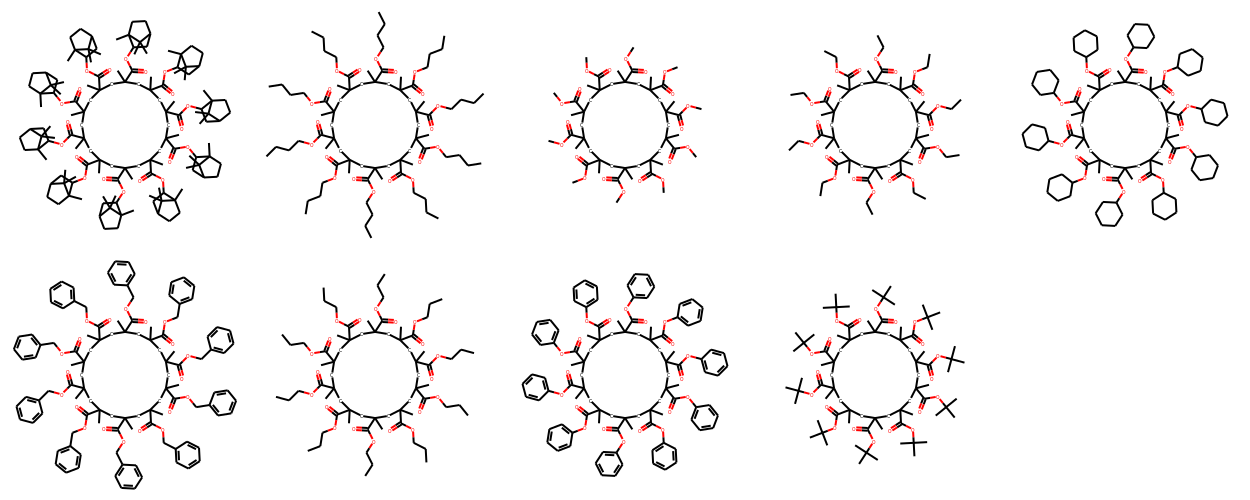

____________________


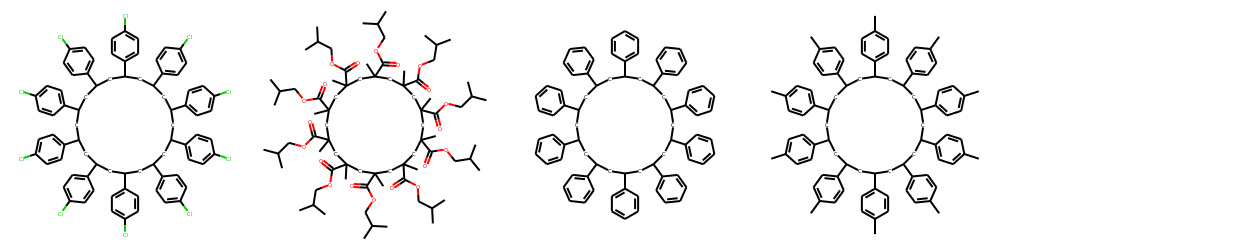

In [195]:
all_smiles = list(train_df["circular_smiles_10"].unique())
display(Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(smiles) for smiles in list(train_df["circular_smiles_10"].unique())],molsPerRow=5,subImgSize=(250,250)))
print("_"*20)
all_smiles.extend(list(test_df["circular_smiles_10"].unique()))
mols=[Chem.MolFromSmiles(smiles) for smiles in all_smiles]
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(smiles) for smiles in list(test_df["circular_smiles_10"].unique())],molsPerRow=5,subImgSize=(250,250))

In [196]:
test_df.loc[np.isnan(test_df["dp"]),"dp"]=400
if "level_0" in test_df.columns:
    test_df.drop("level_0",axis=1,inplace=True)
true2=test_df["z_average"].values
test_df= main2.predict(model,test_df)
pred2= test_df["predicted_z_average"]
test_df["error"] = np.abs(test_df["predicted_z_average"]-test_df["z_average"])
test_df["rel_error"] = test_df["error"]/test_df["z_average"]

In [197]:
mask=(test_df["dp"]==test_df["dp"].max()).values
v=test_df["dp"].max()
print(v)
if "level_0" in test_df.columns:
    test_df.drop("level_0",axis=1,inplace=True)
v=0

406.1371841155236


In [198]:
model.default_filename()

'/home/julian/.smartchem/np_model_9/np_model_1597387853.pth'

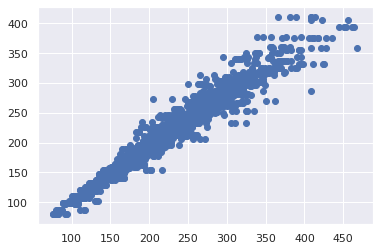

In [199]:
if "level_0" in train_df.columns:
    train_df.drop("level_0",axis=1,inplace=True)
true1=train_df["z_average"].values
train_df= main2.predict(model,train_df)
pred1= train_df["predicted_z_average"]
plt.plot(true1,pred1,"o")

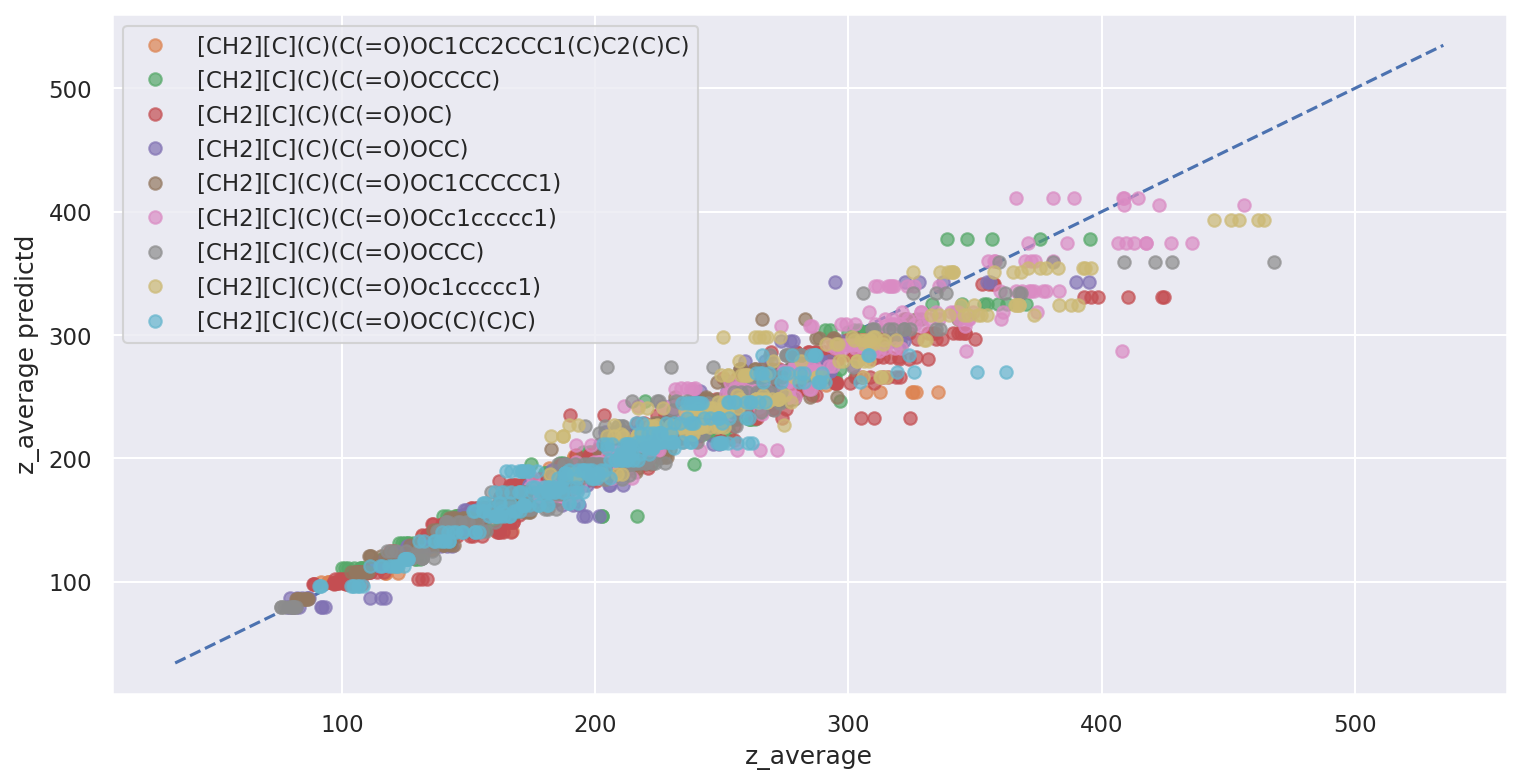

In [200]:
_min = min(true1.min(),true2.min())
_max = max(true1.max(),true2.max())
_min,_max = _min - 0.1*(_max-_min) , _max + 0.1*(_max-_min)
plt.figure(dpi=150,figsize=(12,6))

plt.plot([_min,_max],[_min,_max],"--")
#plt.figure()
for su in train_df.smiles_ru.unique():
    sd = train_df[train_df.smiles_ru == su]
    plt.plot(sd["z_average"],sd["predicted_z_average"],"o",label=su,alpha=0.7)
plt.xlabel("z_average")
plt.ylabel("z_average predictd")
plt.legend()

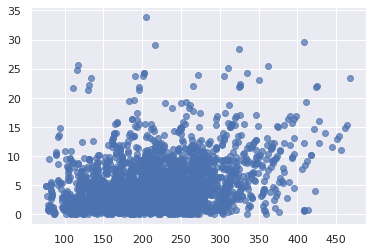

In [201]:
train_df["error"] = 100*np.abs((true1-pred1)/true1)
plt.plot(train_df["z_average"],train_df["error"],"o",label=su,alpha=0.7)

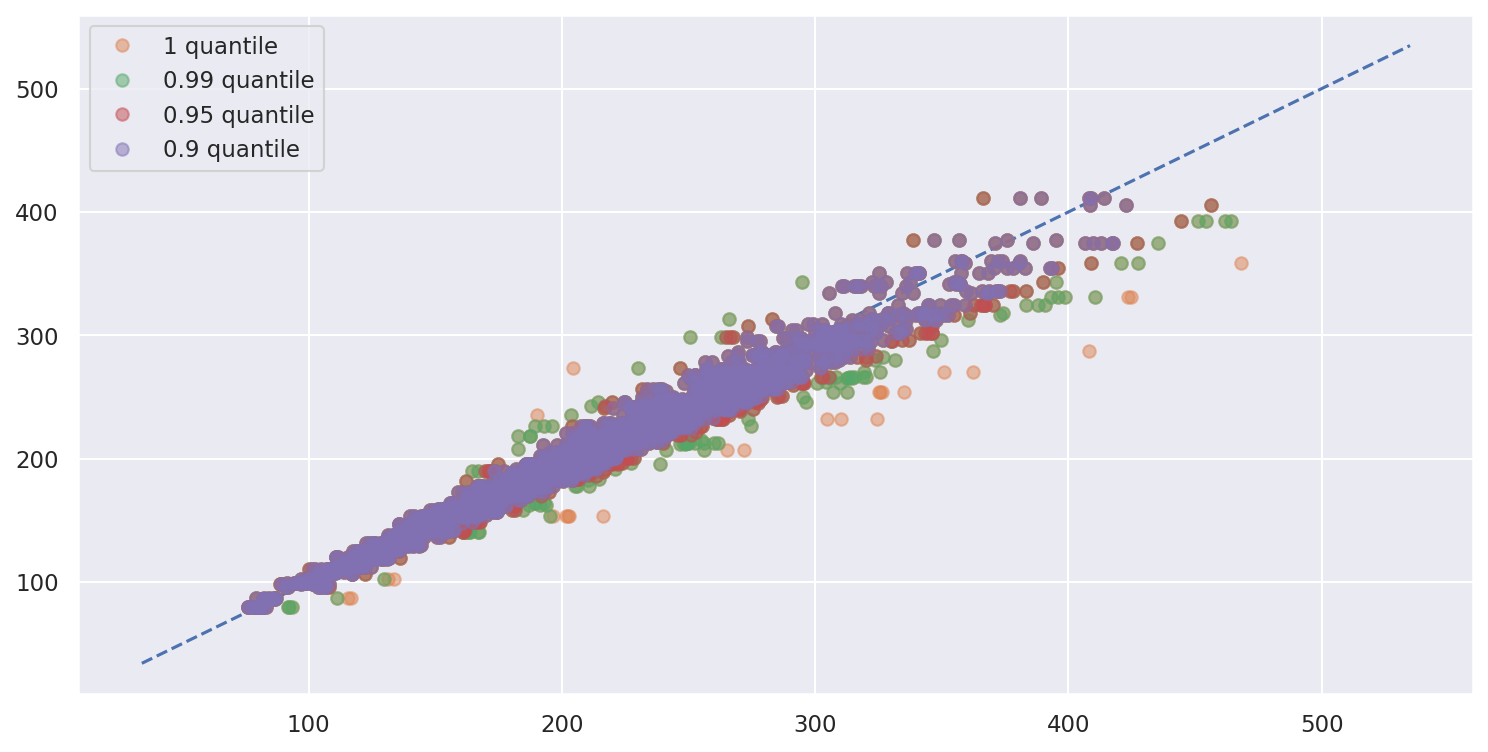

In [202]:
plt.figure(dpi=150,figsize=(12,6))
sorted_indices = np.argsort(train_df["error"])
plt.plot([_min,_max],[_min,_max],"--")
for i,q in enumerate([1,0.99,0.95,0.90]):
    e=int(q*len(sorted_indices))
    plt.plot(train_df["z_average"].iloc[sorted_indices[:e]],
             train_df["predicted_z_average"].iloc[sorted_indices[:e]],
             "o",
             label="{} quantile".format(q),
             alpha=0.5)
plt.legend()
    

Text(0, 0.5, 'Predicted z-average [nm]')

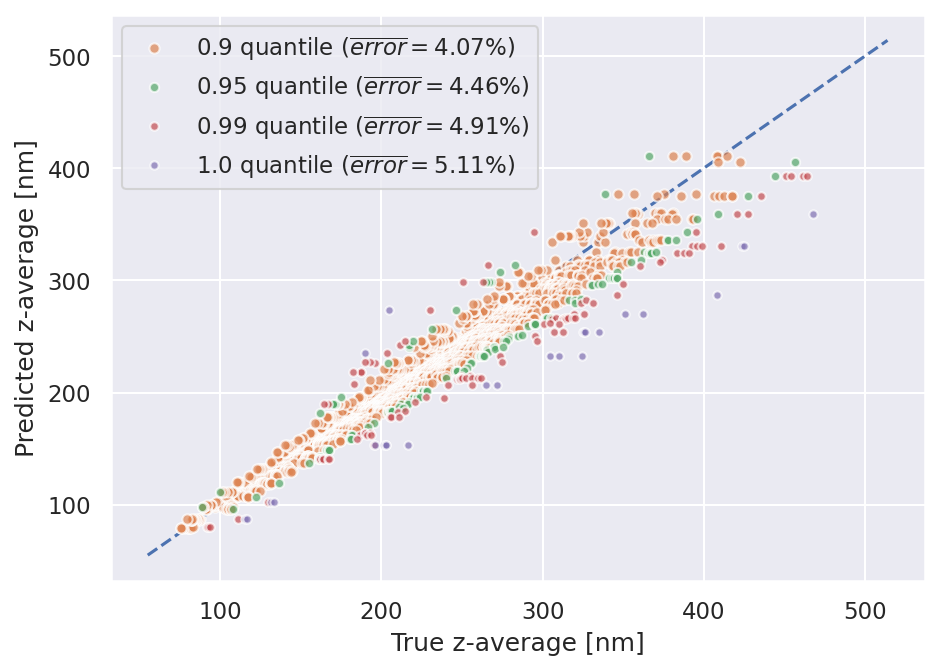

In [203]:
_min = min(true1.min(),true2.min())
_max = max(true1.max(),true2.max())
over=0.05
_min,_max = _min - over*(_max-_min) , _max + over*(_max-_min)
plt.figure(dpi=150,figsize=(7,5))
sorted_indices = np.argsort(train_df["error"])
plt.plot([_min,_max],[_min,_max],"--")
qs=list(sorted([1.,0.99,0.95,0.90]))
for i,q in enumerate(qs):
    if i==0:
        s=0
    else:
        s=int(qs[i-1]*len(sorted_indices))
    e=int(q*len(sorted_indices))   
    plt.plot(train_df["z_average"].iloc[sorted_indices[s:e]],
             train_df["predicted_z_average"].iloc[sorted_indices[s:e]],
             "o",
             label=r"{} quantile ($\overline{{error}}={:.2f}$%)".format(q,train_df["error"].iloc[sorted_indices[:e]].mean()),
             alpha=0.7,
             markeredgecolor=(1,1,1),
             markersize=4/q**2,
            )
plt.legend()
plt.xlabel("True z-average [nm]")
plt.ylabel("Predicted z-average [nm]")

In [71]:
print("",100*np.abs((true1-pred1)/true1).mean())
q=0.75
ar=np.sort(100*np.abs((true1-pred1)/true1))
ar=ar[:int(len(ar)*q)]
print("",ar.mean())

print("",np.quantile(100*np.abs((true1-pred1)/true1),0.75))

print("",100*np.abs((true2-pred2)/true2).mean())
print("",100*np.abs((true2[~mask]-pred2[~mask])/true2[~mask]).mean())

 5.279351758944192
 3.165291871046678
 7.245234203141925
 24.765284703115228
 23.65990116094067


 33.66522164180509
 12.893623531658363
 29.707636549050285
 35.45619168277121


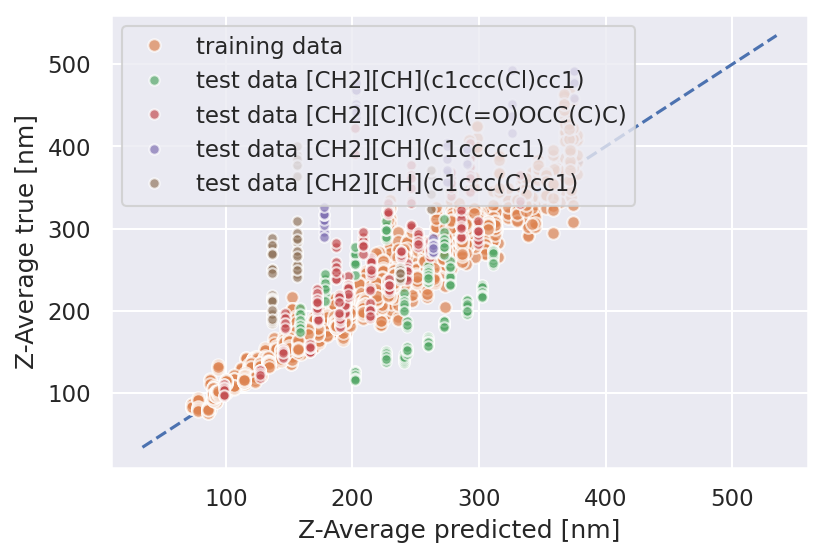

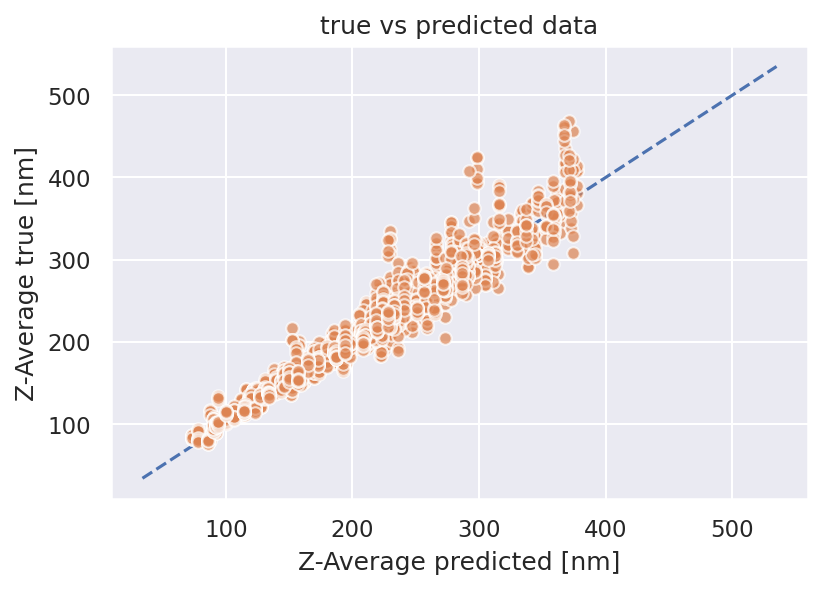

In [55]:
_min = min(true1.min(),true2.min())
_max = max(true1.max(),true2.max())
_min,_max = _min - 0.1*(_max-_min) , _max + 0.1*(_max-_min)
plt.figure(dpi=150)

plt.plot([_min,_max],[_min,_max],"--")

#for i in true1:
#    plt.plot([i,i],[_min,_max],"r--")
#for i in pred1:
#    plt.plot([_min,_max],[i,i],"r--")
#mask=(test_df["dp"]<test_df["dp"].max()).values
plt.plot(pred1,true1,"o",alpha=0.7, markeredgecolor='w',label="training data")
#plt.plot(pred2,true2,"o",alpha=0.7, markeredgecolor='w',label="test data",markersize=8)
#plt.plot(pred2[~mask],true2[~mask],"o",alpha=0.7, markeredgecolor='w',label="test data masked",markersize=5)
for smiles in test_df[~mask].smiles_ru.unique():
    print("",100*test_df[(test_df["smiles_ru"]==smiles)&(~mask)]["rel_error"].mean())
    plt.plot(pred2[(test_df["smiles_ru"]==smiles)&(~mask)],true2[(test_df["smiles_ru"]==smiles)&(~mask)],"o",alpha=0.7, markeredgecolor='w',label="test data "+smiles,markersize=5)

plt.ylabel("Z-Average true [nm]")
plt.xlabel("Z-Average predicted [nm]")
plt.legend()
plt.show()
plt.close()

plt.figure(dpi=150)

plt.plot([_min,_max],[_min,_max],"--")

#for i in true1:
#    plt.plot([i,i],[_min,_max],"r--")
#for i in pred1:
#    plt.plot([_min,_max],[i,i],"r--")
    
plt.plot(pred1,true1,"o",alpha=0.7, markeredgecolor='w',label="training data")
plt.ylabel("Z-Average true [nm]")
plt.xlabel("Z-Average predicted [nm]")
plt.title("true vs predicted data")
plt.show()
plt.close()

0
0 [CH2][CH](c1ccccc1) 3
33
1 [CH2][CH](c1ccccc1) 5
43
2 [CH2][CH](c1ccccc1) 1
70
3 [CH2][CH](c1ccc(Cl)cc1) 5
106
4 [CH2][CH](c1ccc(C)cc1) 3
135
5 [CH2][CH](c1ccc(Cl)cc1) 8
161
6 [CH2][C](C)(C(=O)OCC(C)C) 10
207
7 [CH2][CH](c1ccccc1) 8
211
8 [CH2][CH](c1ccc(Cl)cc1) 10
229
9 [CH2][CH](c1ccc(Cl)cc1) 1
256
10 [CH2][CH](c1ccc(C)cc1) 1
292
11 [CH2][CH](c1ccccc1) 15
298


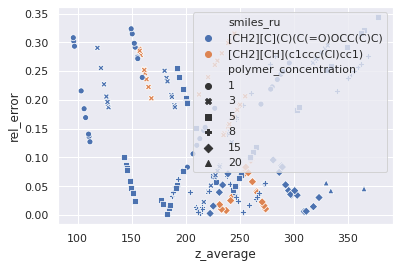

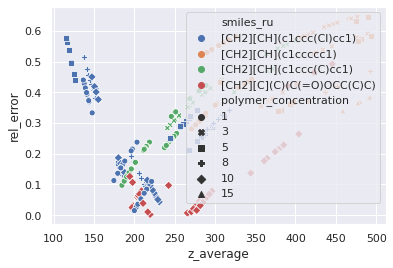

 13.96216962557797


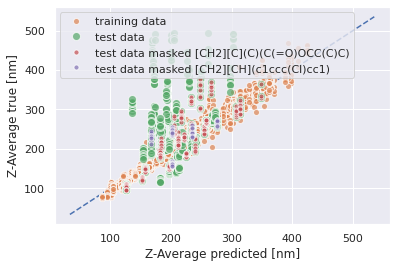

In [642]:
mask=~(test_df["smiles_ru"]==test_df["smiles_ru"])
print(mask.sum())

for i in range(12):
    out_m1="smiles_ru"
    out_m2="polymer_concentration"
    out1=(test_df[~mask][test_df[~mask]["rel_error"] == test_df[~mask]["rel_error"].max()])[out_m1].to_list()[0]
    out2=(test_df[~mask][test_df[~mask]["rel_error"] == test_df[~mask]["rel_error"].max()])[out_m2].to_list()[0]
    print(i,out1,out2)
    mask=mask|((test_df[out_m1]==out1)&(test_df[out_m2]==out2))
    print(mask.sum())


#out_m="smiles_ru"
#out=(test_df[~mask][test_df[~mask]["rel_error"] == test_df[~mask]["rel_error"].max()])[out_m].to_list()[0]
#print(out)
#mask=mask|(test_df[out_m]==out)
#print(mask.sum())

#out_m="smiles_ru"
#out=(test_df[~mask][test_df[~mask]["rel_error"] == test_df[~mask]["rel_error"].max()])[out_m].to_list()[0]
#print(out)
#mask=mask|(test_df[out_m]==out)
#print(mask.sum())

#out_m="dp"
#out=(test_df[~mask][test_df[~mask]["rel_error"] == test_df[~mask]["rel_error"].max()])[out_m].to_list()[0]
#print(out)
#mask=mask|(test_df[out_m]==out)
#print(mask.sum())

test_df.sort_values("error",ascending=False)
import seaborn as sls
sls.scatterplot(y="rel_error",x="z_average",data=test_df[~mask],style="polymer_concentration",hue="smiles_ru",legend="full")
plt.show()
plt.close()
sls.scatterplot(y="rel_error",x="z_average",data=test_df[mask],style="polymer_concentration",hue="smiles_ru",legend="full")#smiles_ru
plt.show()
plt.close()
print("",100*np.abs((true2[~mask]-pred2[~mask])/true2[~mask]).mean())
plt.plot([_min,_max],[_min,_max],"--")
plt.plot(pred1,true1,"o",alpha=0.7, markeredgecolor='w',label="training data")
plt.plot(pred2,true2,"o",alpha=0.7, markeredgecolor='w',label="test data",markersize=8)
p=pred2[~mask]
for smiles in test_df[~mask].smiles_ru.unique():
    plt.plot(pred2[(test_df["smiles_ru"]==smiles)&(~mask)],true2[(test_df["smiles_ru"]==smiles)&(~mask)],"o",alpha=0.7, markeredgecolor='w',label="test data masked "+smiles,markersize=5)
plt.ylabel("Z-Average true [nm]")
plt.xlabel("Z-Average predicted [nm]")
plt.legend()
plt.show()
plt.close()

In [639]:
print(test_df[~mask].smiles_ru.unique())
test_df.columns

['[CH2][C](C)(C(=O)OCC(C)C)' '[CH2][CH](c1ccc(Cl)cc1)']


Index(['index', 'measurment_data', 'sample', 'temperature', 'z_average',
       'dispersity', 'mean_count_rate', 'volume_mean', 'intensity_mean',
       'number_mean', 'file', 'np_formulation', 'substance_code',
       'polymer_class', 'polymer', 'smiles_monomer', 'smiles_ru', 'mn', 'pdi',
       'mn_method', 'tg', 'date', 'additive', 'polymer_concentration',
       'mass_ru', 'circular_smiles_10', 'dp', 'valid', 'mean_z_average',
       'roll_valid', 'with_pva', 'predicted_z_average', 'error', 'rel_error'],
      dtype='object')

In [540]:

#out=(test_df[~mask][test_df[~mask]["error"] == test_df[~mask]["error"].max()])["dp"].to_list()[0]
#print(out)
#mask=mask|(test_df["dp"]==out)
#print(mask.sum())

#out=(test_df[~mask][test_df[~mask]["error"] == test_df[~mask]["error"].max()])["smiles_ru"].to_list()[0]
#print(out)
#mask=mask|(test_df["smiles_ru"]==out)
#print(mask.sum())

#out=(test_df[~mask][test_df[~mask]["error"] == test_df[~mask]["error"].max()])["smiles_ru"].to_list()[0]
#print(out)
#mask=mask|(test_df["smiles_ru"]==out)
#print(mask.sum())

0


458
1.0


<Figure size 432x288 with 0 Axes>

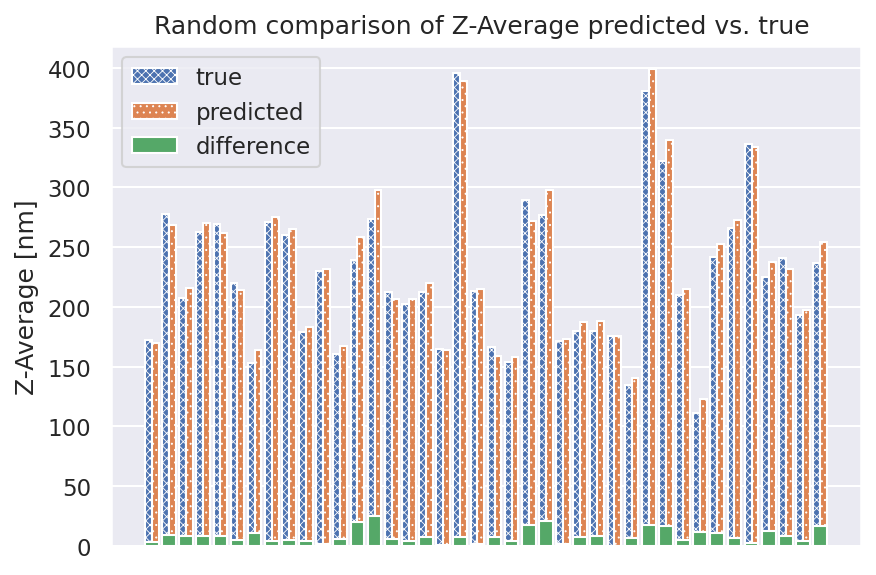

In [106]:
plt.figure()
fig,a = plt.subplots(dpi=150)
idx  = np.arange(len(true1))
seed = np.random.randint(1000)
seed=458
print(seed)
np.random.seed(seed)
idx=np.random.choice(idx,size=40)
width=0.4
prehw=plt.rcParams['hatch.linewidth']
print(prehw)
plt.rcParams['hatch.linewidth']=0.4
a.bar(np.arange(len(idx)) - width/2,true1[idx],width,label="true", hatch="xxxxxx")
a.bar(np.arange(len(idx)) + width/2,pred1[idx],width,label="predicted", hatch="....")
a.bar(np.arange(len(idx)),np.abs(true1[idx]-pred1[idx]),label="difference")
plt.ylabel("Z-Average [nm]")
plt.title("Random comparison of Z-Average predicted vs. true ")
a.axes.xaxis.set_visible(False)
plt.legend()
plt.tight_layout()
plt.show()
plt.close()
plt.rcParams['hatch.linewidth']=prehw

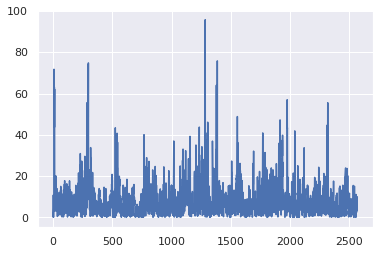

In [107]:
plt.plot(np.abs(pred1-true1))

In [108]:
full_df=pd.DataFrame(columns=config.get("model","additional_input_names"))
df_data=[]
for smiles in all_smiles:
    for conc in concentrations:
        for deg in poly_deg:
            for wpva in [0,1]:
                full_df = df_data.append({
                    'dp' : deg,
                    'polymer_concentration' : conc,
                    "pdi":1,
                    "with_pva":wpva,
                    'circular_smiles_10':smiles
                })
full_df = pd.DataFrame(df_data)
full_df

dp  polymer_concentration  pdi  with_pva  \
0        10.000000                    0.0    1         0   
1        10.000000                    0.0    1         1   
2        12.929293                    0.0    1         0   
3        12.929293                    0.0    1         1   
4        15.858586                    0.0    1         0   
...            ...                    ...  ...       ...   
199995  294.141414                   30.0    1         1   
199996  297.070707                   30.0    1         0   
199997  297.070707                   30.0    1         1   
199998  300.000000                   30.0    1         0   
199999  300.000000                   30.0    1         1   

                                       circular_smiles_10  
0       C3[C](C)(C(=O)OC1CC2CCC1(C)C2(C)C)[CH2][C](C)(...  
1       C3[C](C)(C(=O)OC1CC2CCC1(C)C2(C)C)[CH2][C](C)(...  
2       C3[C](C)(C(=O)OC1CC2CCC1(C)C2(C)C)[CH2][C](C)(...  
3       C3[C](C)(C(=O)OC1CC2CCC1(C)C2(C)C)[CH2][C](C)(...  
4       C3[C](C)(C(=O)OC1CC2CCC1(C)C2(C)C)[CH2][C](C)(...  
...                                                   ...  
199995  C3[C](C)(C(=O)OCC(C)C)[CH2][C](C)(C(=O)OCC(C)C...  
199996  C3[C](C)(C(=O)OCC(C)C)[CH2][C](C)(C(=O)OCC(C)C...  
199997  C3[C](C)(C(=O)OCC(C)C)[CH2][C](C)(C(=O)OCC(C)C...  
199998  C3[C](C)(C(=O)OCC(C)C)[CH2][C](C)(C(=O)OCC(C)C...  
199999  C3[C](C)(C(=O)OCC(C)C)[CH2][C](C)(C(=O)OCC(C)C...  

[200000 rows x 5 columns]

In [109]:
pred_df = main2.predict(model,full_df)

In [110]:
import rdkit
import cairosvg
from PIL import Image
import os
def to_rdk_transparent_png(mol ):
    dr = rdkit.Chem.Draw.rdMolDraw2D.MolDraw2DSVG( 200, 200 )
    #dr.SetFontSize( 0.27 )
    op = dr.drawOptions()
    #for i in range( mol.GetNumAtoms() ) :
    #    op.atomLabels[i]=mol.GetAtomWithIdx(i).GetSymbol()+str((i+1))
    rdkit.Chem.AllChem.Compute2DCoords( mol )
    dr.DrawMolecule( mol )
    dr.FinishDrawing()
    
    svg = dr.GetDrawingText()
    svg =  svg.replace("<rect style='opacity:1.0;fill:#","<rect style='opacity:0.0;fill:#")
    
    cairosvg.svg2png(svg,write_to ="temp.png")
    img = Image.open("temp.png")
    return img

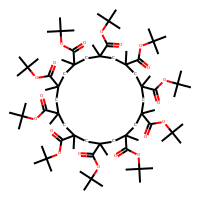

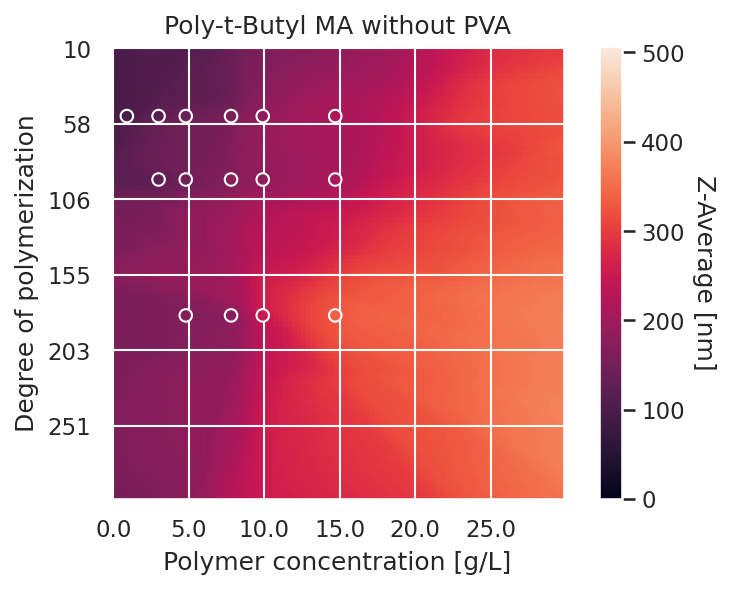

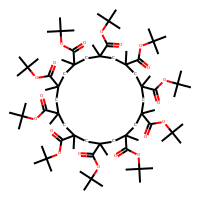

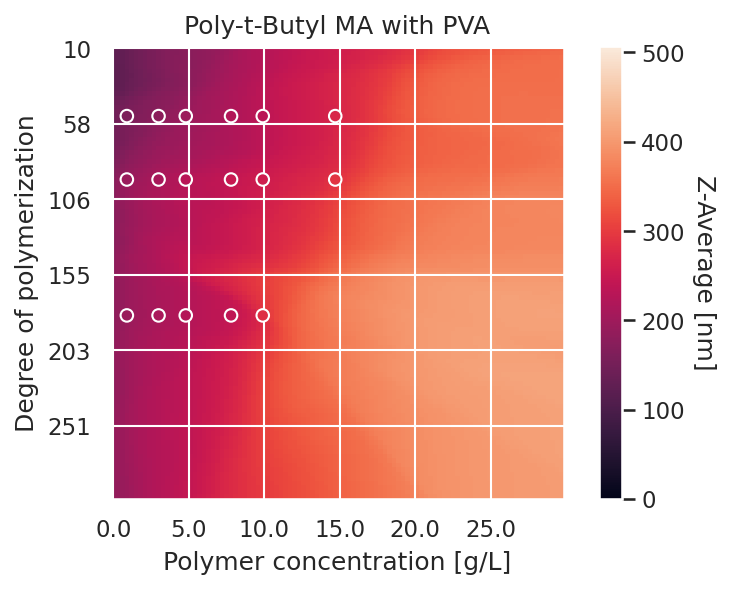

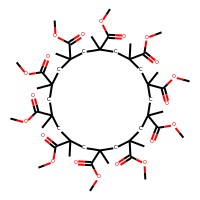

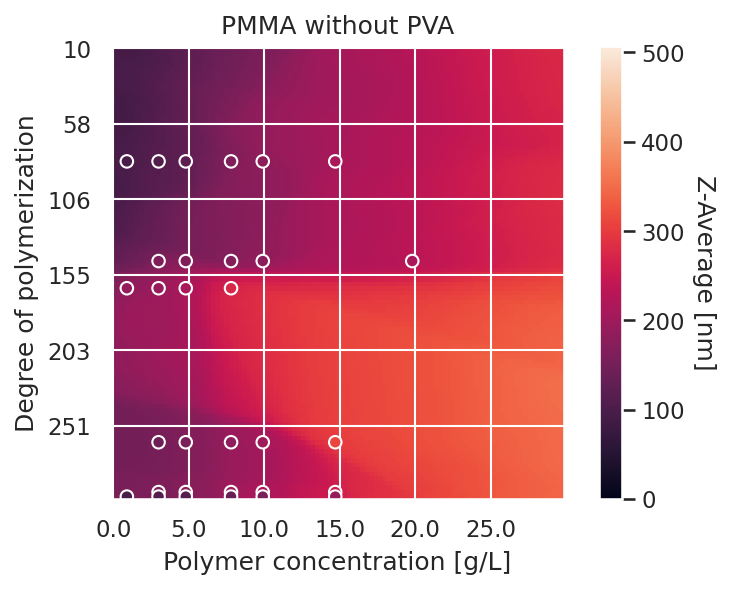

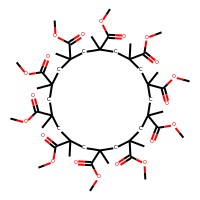

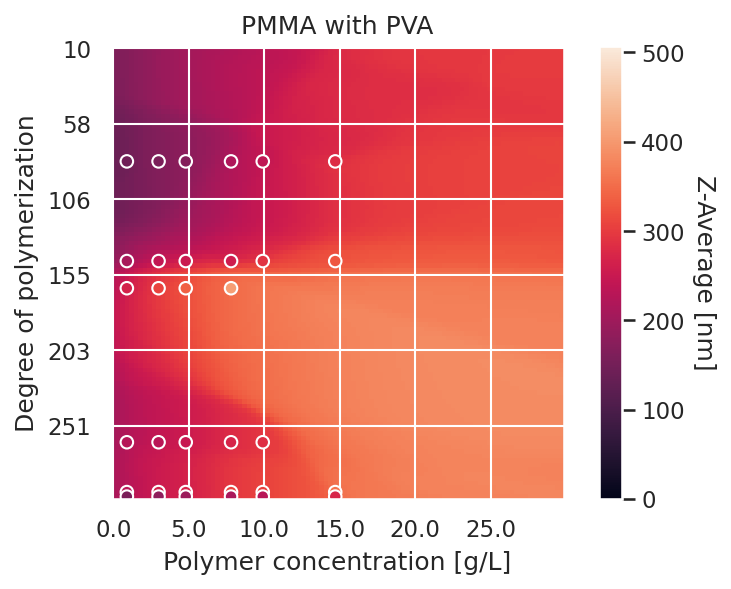

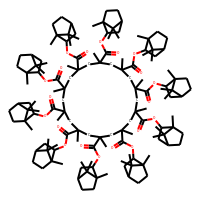

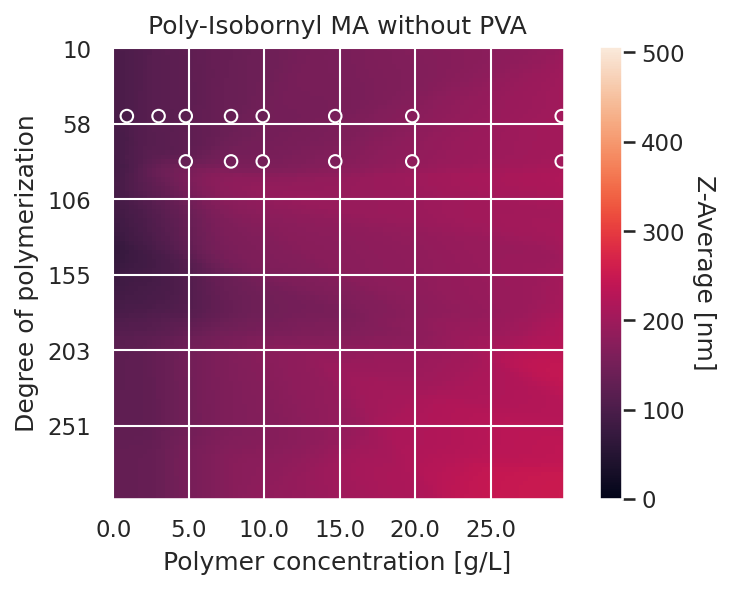

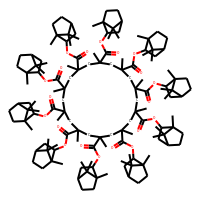

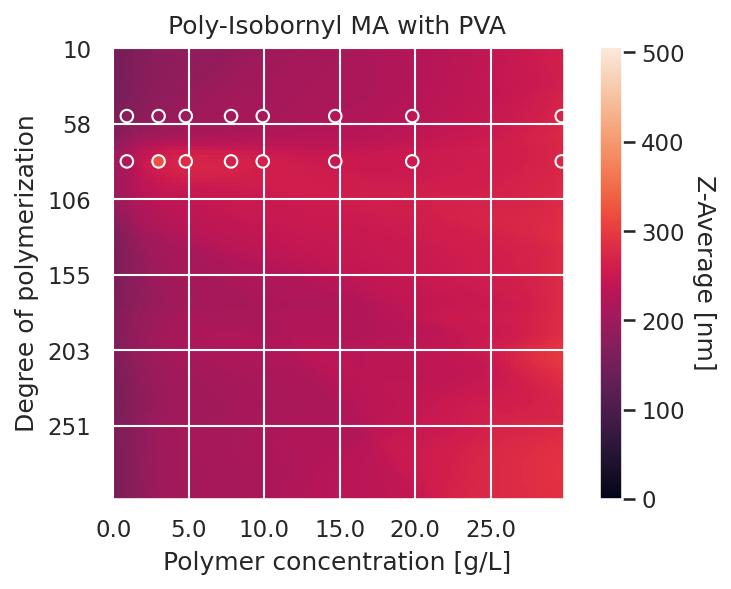

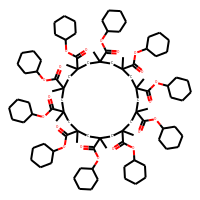

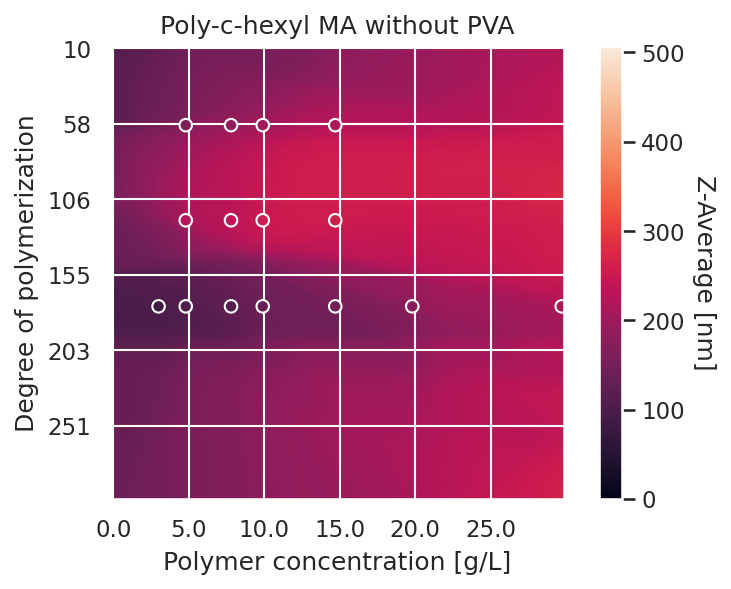

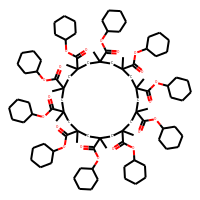

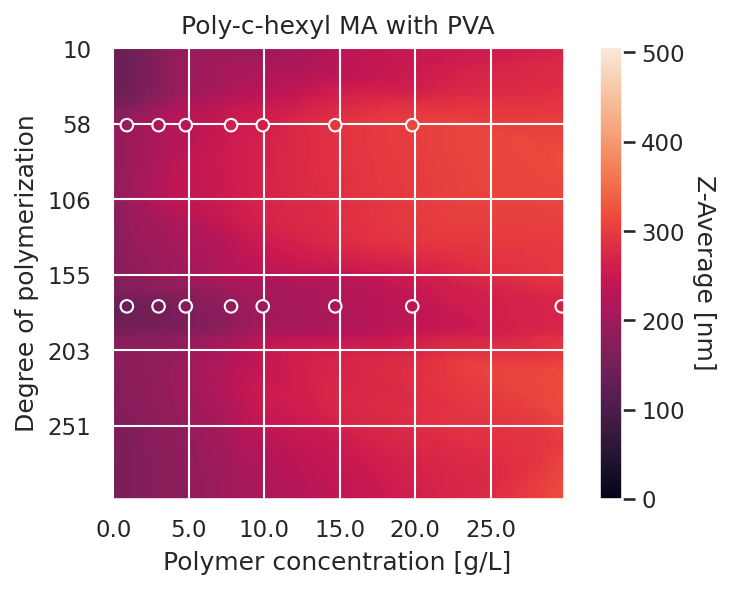

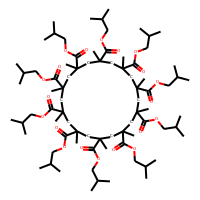

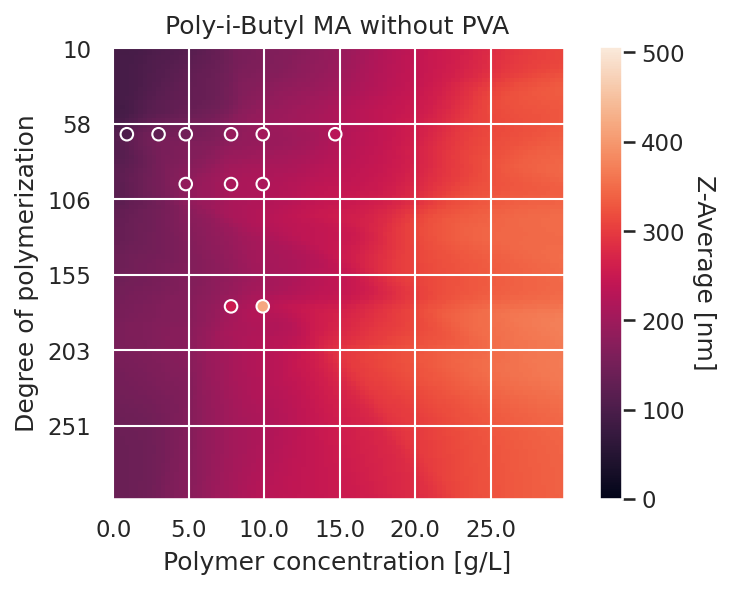

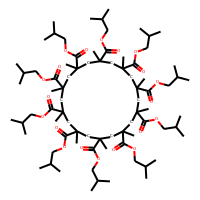

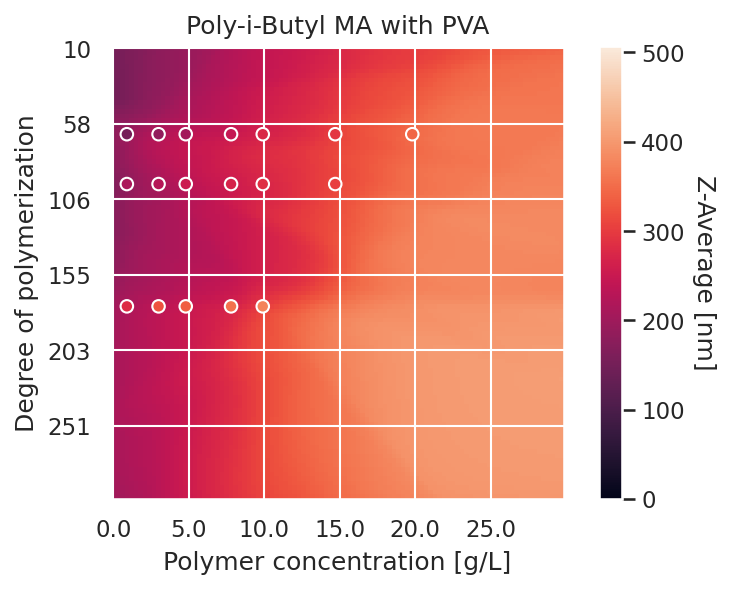

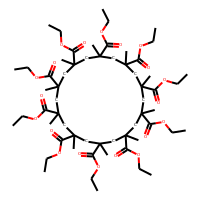

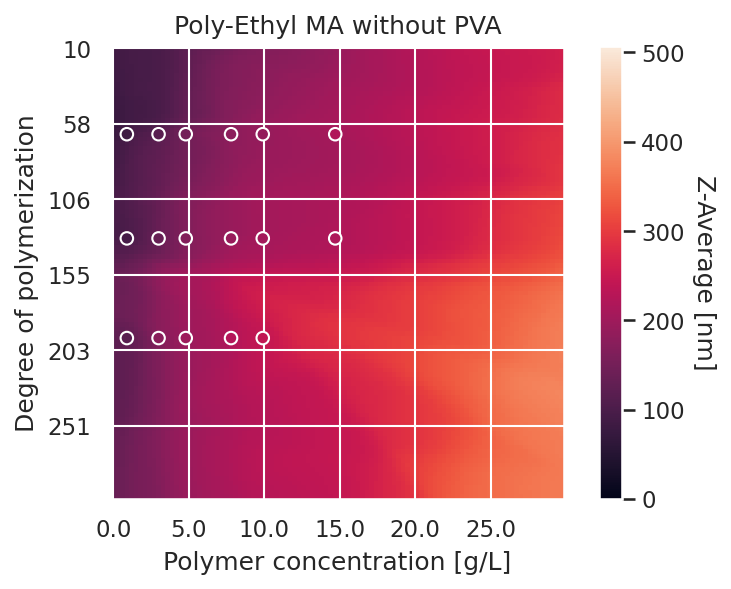

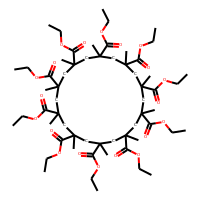

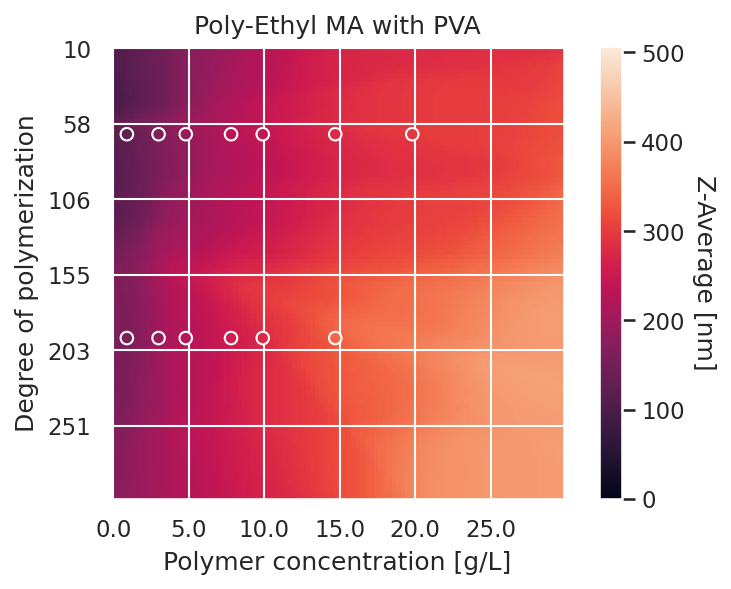

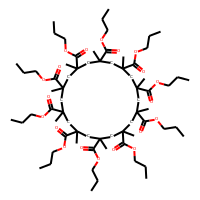

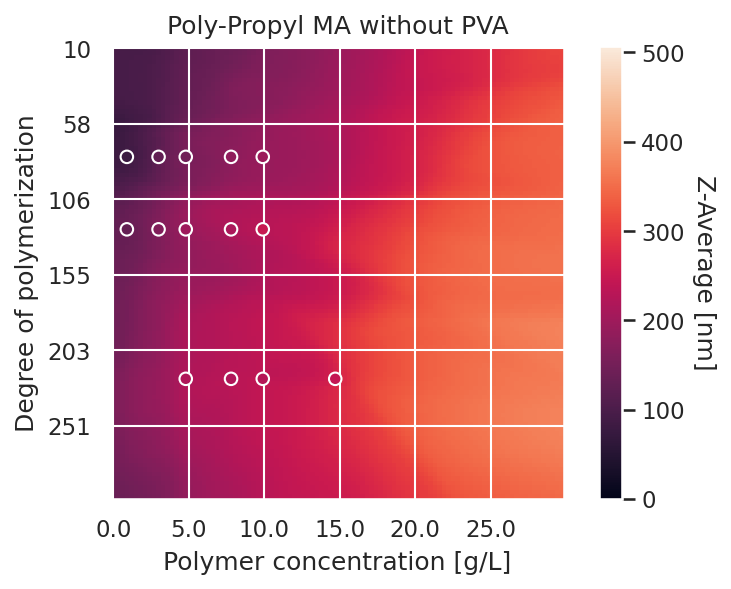

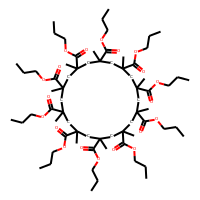

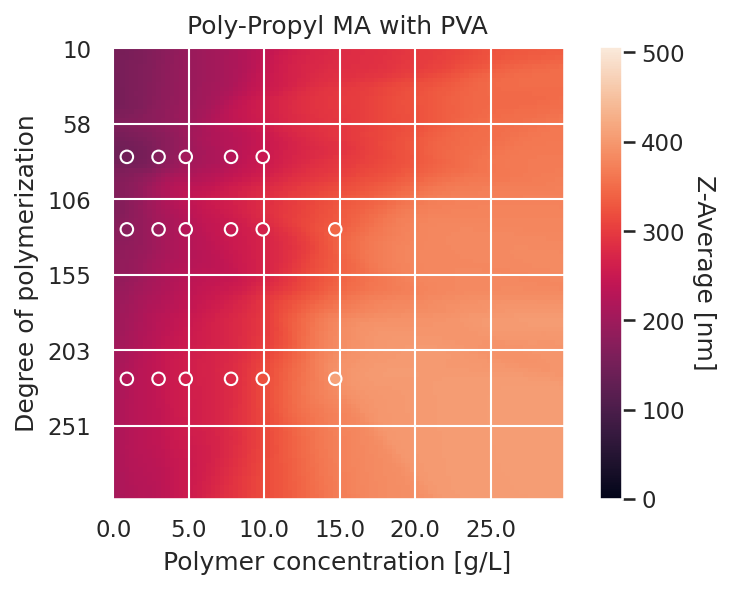

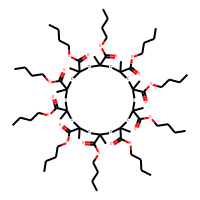

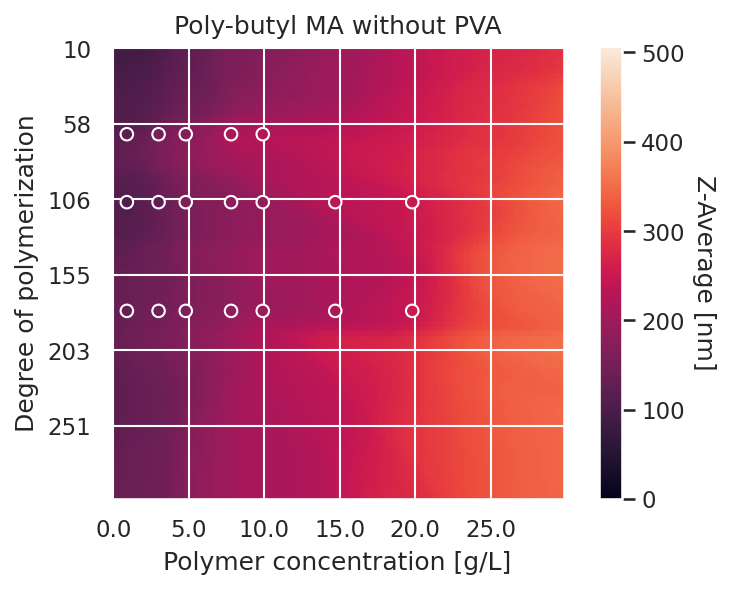

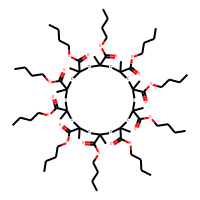

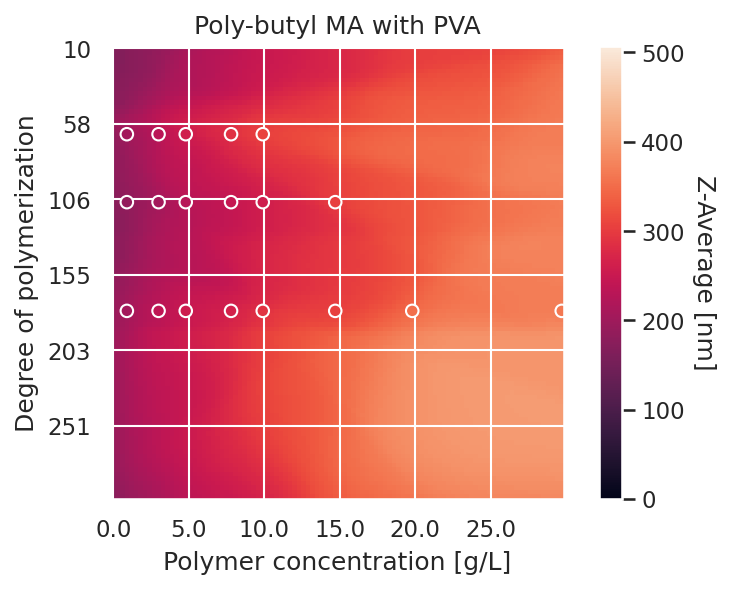

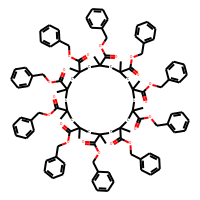

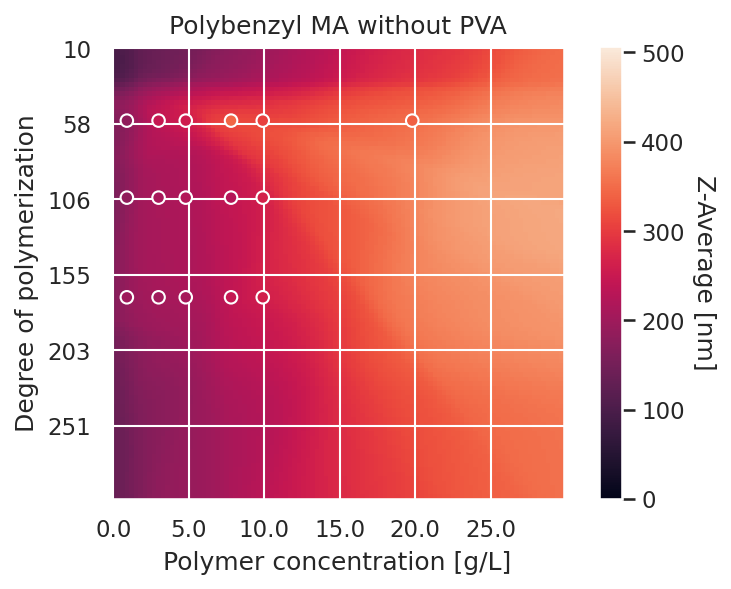

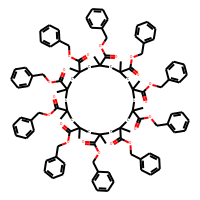

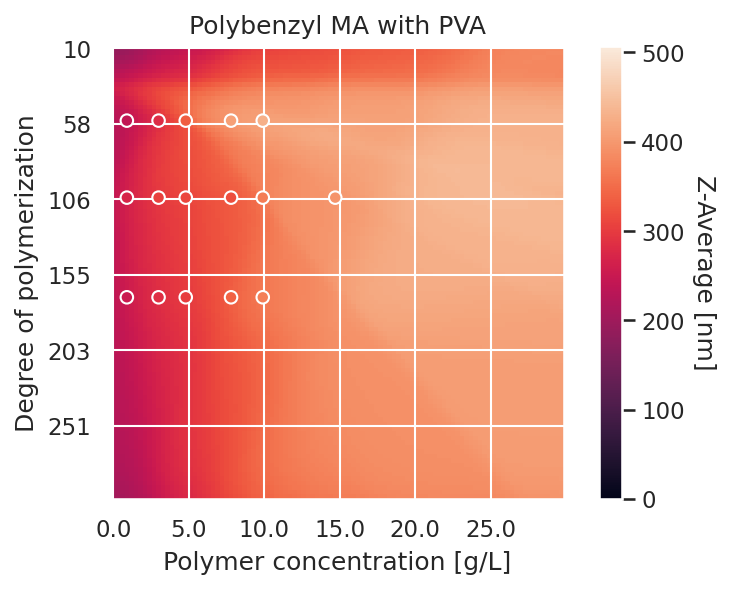

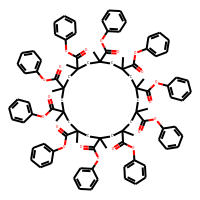

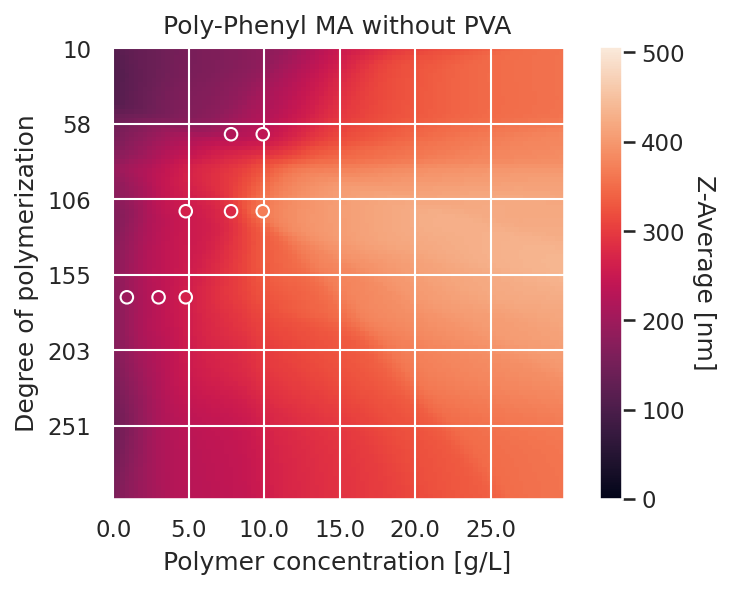

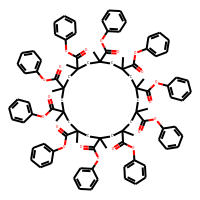

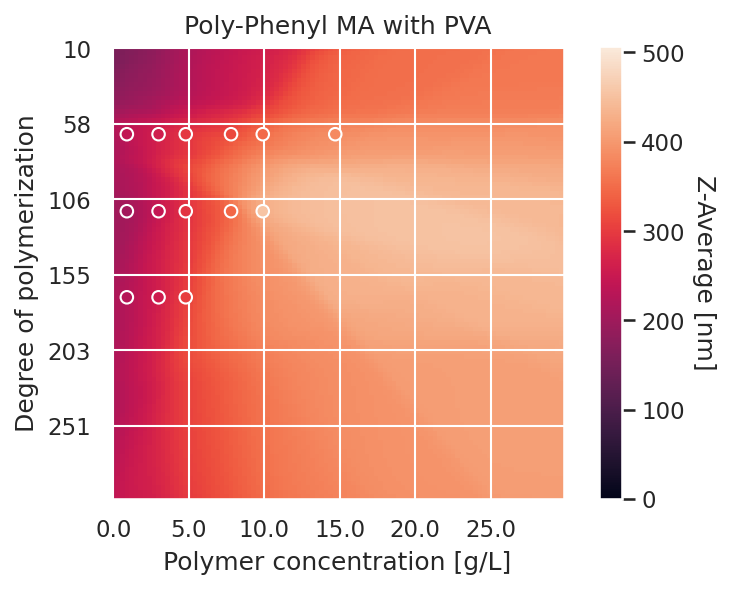

In [111]:
z_max=train_df["z_average"].max()
z_max=_max
z_min=0#train_df["z_average"].min()
for (smiles,with_pva), smiles_df in pred_df.groupby(["circular_smiles_10","with_pva"]):
    sd = train_df[(train_df["circular_smiles_10"]==smiles)]
    if len(sd.dp.unique()) >0:
        pass
    else:
        sd = test_df[(test_df["circular_smiles_10"]==smiles)]
    
    plt.figure(dpi=150)
    predicted_z_average = smiles_df["predicted_z_average"].values.astype(float)
    #print(predicted_z_average)
    XY_pred = (predicted_z_average.reshape(len(concentrations),-1)).T
    plt.imshow(XY_pred,
                    #extent=[c_min,c_max,30,0],
         #            yticklabels=yticks
                    )
    plt.clim(z_min,z_max) 
    
    
    sd = sd[sd["with_pva"]==with_pva]
    #sd = sd[sd["with_pva"]==with_pva]
    dps=[]
    poly_conc=[]
    z_average=[]
    for (dp,polymer_concentration), point_group in sd.groupby(["dp","polymer_concentration"]):
        dps.append(dp)
        poly_conc.append(polymer_concentration)
        z_average.append(point_group["z_average"].mean())
    new_dps=[np.argmin(np.abs(poly_deg-deg)) for deg in dps]
    new_conc=[np.argmin(np.abs(concentrations-conc)) for conc in poly_conc]
    
    k=7
    old_xticks = plt.xticks()
    plt.xticks(np.linspace(0,old_xticks[0].max(),k), np.round(np.linspace(concentrations.min(),concentrations.max(),k)))
    
    old_yticks = plt.yticks()
    plt.yticks(np.linspace(0,len(poly_deg),k), np.linspace(poly_deg.min(),poly_deg.max(),k,dtype=int))
    
    plt.scatter(new_conc,new_dps,c=z_average,edgecolors="w")
    plt.clim(z_min,z_max) 
    
    plt.xlabel("Polymer concentration [g/L]")
    plt.ylabel("Degree of polymerization")
 
    
    plt.title("{} {} PVA".format(sd.polymer.unique()[0], "with" if with_pva else "without",))
    display(to_rdk_transparent_png(Chem.MolFromSmiles(smiles)))
    
    cbar = plt.colorbar()

    cbar.ax.get_yaxis().labelpad = 15
    cbar.ax.set_ylabel('Z-Average [nm]', rotation=270)
    plt.show()
    plt.close()
    display()
    
    #xypred = prednp.reshape((d_res,c_res))

Batch(additional_input=[25, 3], batch=[4980], edge_index=[2, 10320], x=[4980, 54], y=[25])


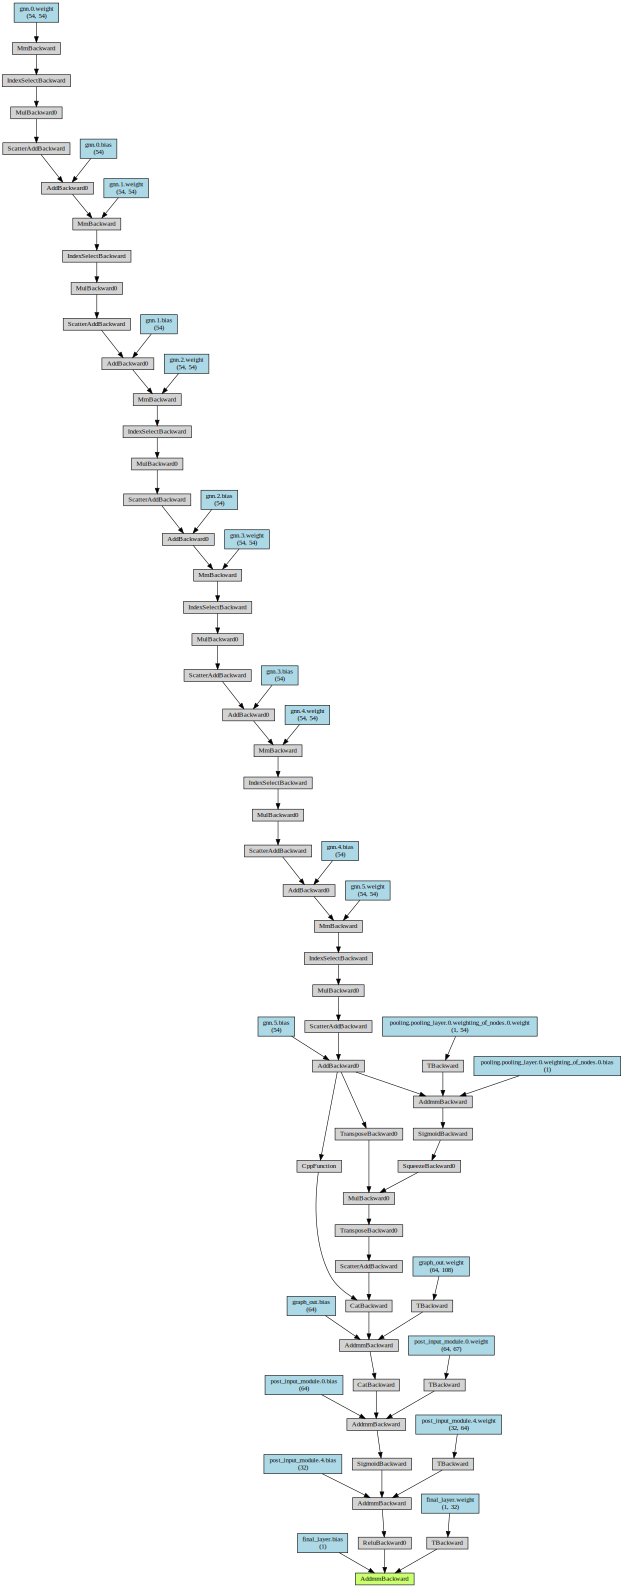

In [15]:
from torchviz import make_dot, make_dot_from_trace
#print(model.last_prediction_tensor)
print(model.last_input_data)

make_dot(model.predict_function(model.module, model.last_input_data, model.device), params=dict(model.module.named_parameters()))

In [28]:
import torch

class AttrDict(dict):
    def __init__(self,obj):
        for k,v in obj.__dict__.items():
            if not k.startswith("__"):
                self[k]=v
            setattr(self,k,v)
ad = AttrDict(model.last_input_data)
print(ad)

with torch.onnx.set_training(model.module, False):
    trace, _ = torch.jit._get_trace_graph(model.module, args=(ad,))
make_dot_from_trace(trace)



{'x': tensor([[1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0101],
        [1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0101],
        [1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0101],
        ...,
        [0.0000, 1.0000, 0.0000,  ..., 0.0000, 0.0000, 0.1201],
        [0.0000, 1.0000, 0.0000,  ..., 0.0000, 0.0000, 0.1201],
        [0.0000, 1.0000, 0.0000,  ..., 0.0000, 0.0000, 0.1201]],
       device='cuda:0'), 'edge_index': tensor([[ 134,  138,  138,  ..., 4885, 4974, 4893],
        [ 138,  134,  124,  ..., 4966, 4893, 4974]], device='cuda:0'), 'edge_attr': None, 'y': tensor([512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525,
        526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536],
       device='cuda:0'), 'pos': None, 'norm': None, 'face': None, 'batch': tensor([ 0,  0,  0,  ..., 24, 24, 24], device='cuda:0'), 'additional_input': tensor([[400.0000,   0.0000,   1.0000],
        [400.0000,   0.0000,   1.0000],
        [400.0000,   0.0000,   1.000

RuntimeError: Only tuples, lists and Variables supported as JIT inputs/outputs. Dictionaries and strings are also accepted but their usage is not recommended. But got unsupported type NoneType

('additional_input', tensor([[400.0000,   0.0000,   1.0000],
        [400.0000,   0.0000,   1.0000],
        [400.0000,   0.0000,   1.0000],
        [400.0000,   0.0000,   1.0000],
        [400.0000,   0.0000,   1.0000],
        [400.0000,   0.0000,   1.0000],
        [400.0000,   0.0000,   1.0000],
        [400.0000,   0.0000,   3.0000],
        [400.0000,   0.0000,   3.0000],
        [400.0000,   0.0000,   3.0000],
        [400.0000,   0.0000,   3.0000],
        [400.0000,   0.0000,   3.0000],
        [400.0000,   0.0000,   3.0000],
        [400.0000,   0.0000,   3.0000],
        [ 97.7510,   0.0000,  10.0000],
        [ 97.7510,   0.0000,  10.0000],
        [ 97.7510,   1.0000,  10.0000],
        [ 97.7510,   1.0000,  10.0000],
        [ 97.7510,   1.0000,  10.0000],
        [ 97.7510,   1.0000,  10.0000],
        [ 97.7510,   1.0000,  10.0000],
        [ 66.2493,   0.0000,   1.0000],
        [ 66.2493,   0.0000,   1.0000],
        [ 66.2493,   0.0000,   1.0000],
        [ 66.2493, 

In [112]:
config = JsonDict(config_file_validity)
model = main.load_model(config.getsubdict("model"))
pred_df = main.predict(model,pred_df)

NameError: name 'main' is not defined

In [ ]:
z_max=train_df["z_average"].max()
z_max=600
z_min=train_df["z_average"].min()
for (smiles,with_pva), smiles_df in pred_df.groupby(["circular_smiles_10","with_pva"]):
    predicted_z_average = smiles_df["predicted_roll_valid"].values.astype(float)
    #print(predicted_z_average)
    XY_pred = (predicted_z_average.reshape(len(concentrations),-1)).T
    plt.imshow(XY_pred,
                    #extent=[c_min,c_max,30,0],
         #            yticklabels=yticks
                    )
    plt.clim(0,1) 
    
    sd = train_df[(train_df["circular_smiles_10"]==smiles)]
    sd = sd[sd["with_pva"]==with_pva]
    #dps=[]
    #poly_conc=[]
    #z_average=[]
    #for (dp,polymer_concentration), point_group in sd.groupby(["dp","polymer_concentration"]):
    #    dps.append(dp)
    #    poly_conc.append(polymer_concentration)
    #    z_average.append(point_group["z_average"].mean())
    #new_dps=[np.argmin(np.abs(poly_deg-deg)) for deg in dps]
    #new_conc=[np.argmin(np.abs(concentrations-conc)) for conc in poly_conc]
    #plt.scatter(new_conc,new_dps,c=z_average,edgecolors="w")
    #plt.clim(0,z_max) 
    
    print(with_pva)
    display(Chem.MolFromSmiles(smiles))
    
    plt.colorbar()
    plt.show()
    plt.close()
    
    #xypred = prednp.reshape((d_res,c_res))

0


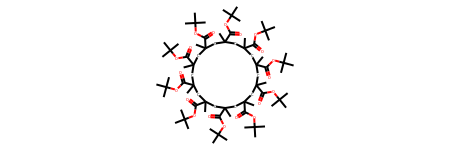

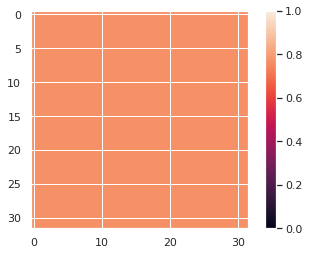

1


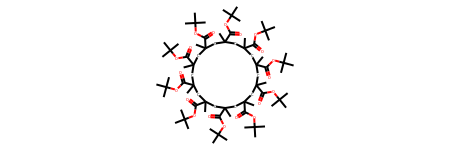

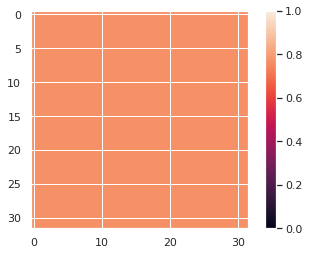

0


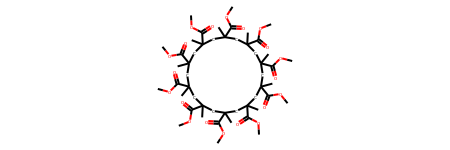

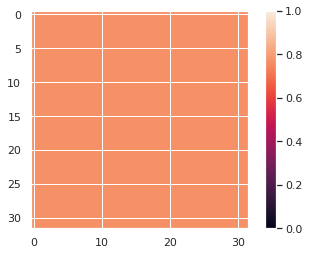

1


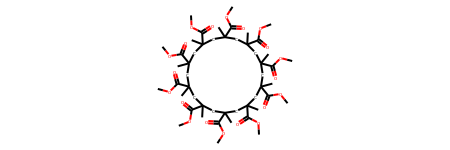

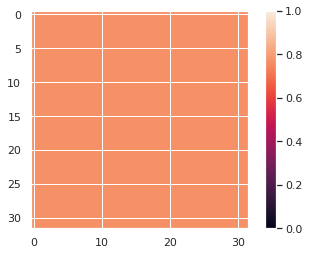

0


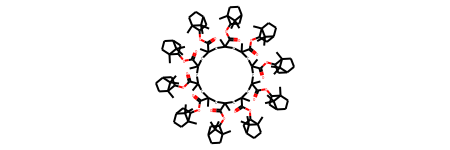

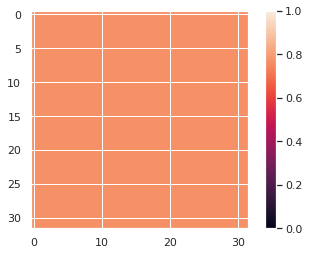

1


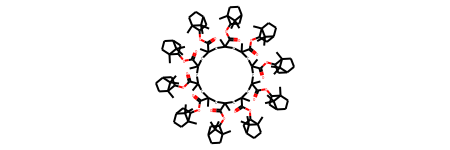

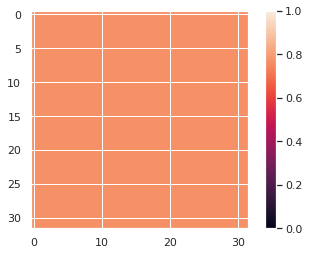

0


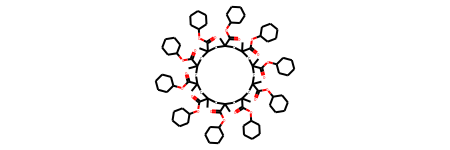

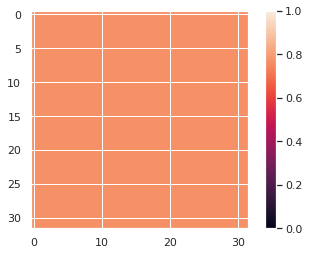

1


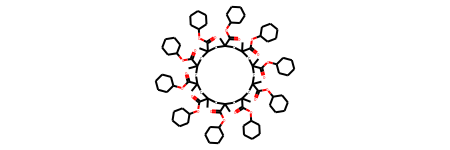

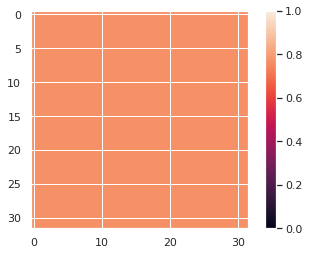

0


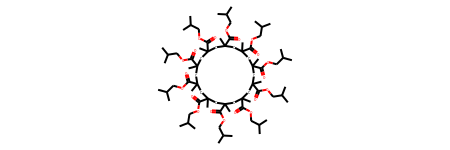

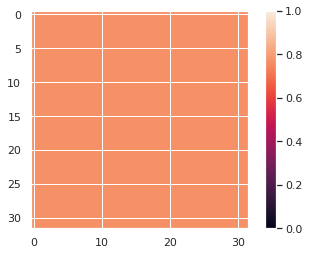

1


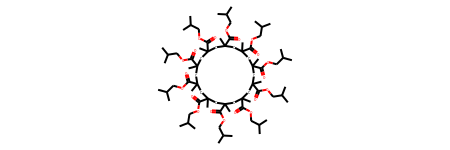

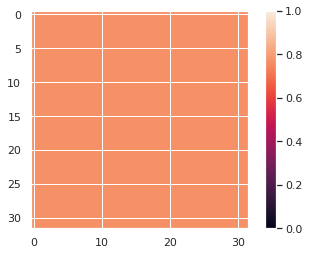

0


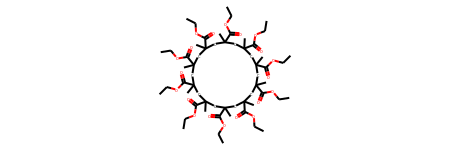

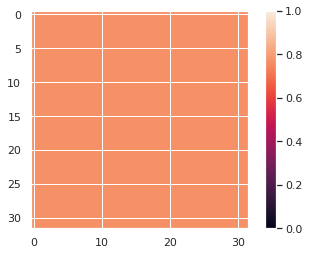

1


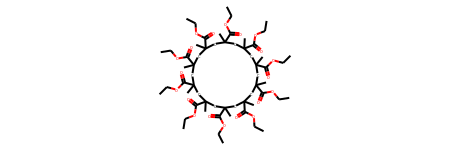

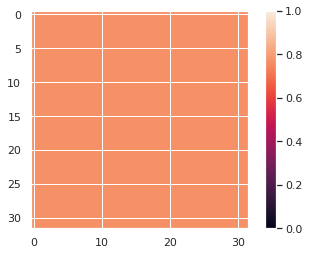

0


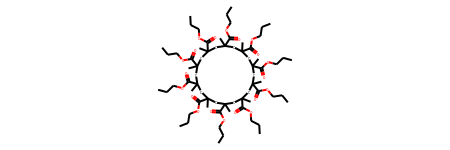

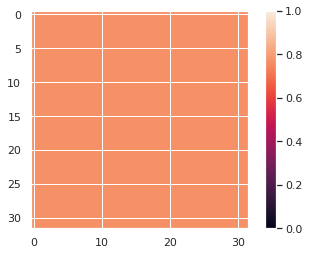

1


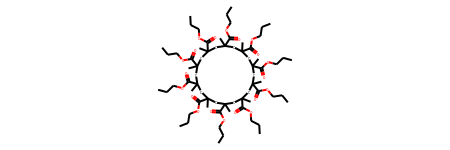

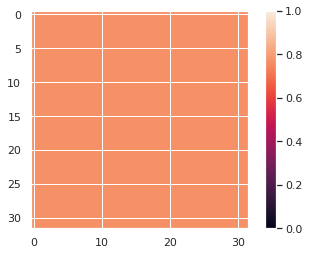

0


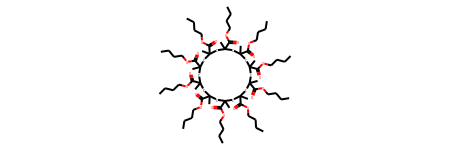

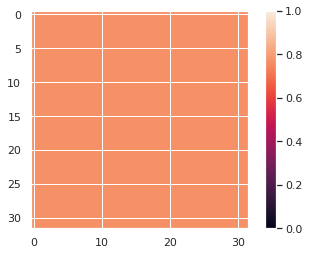

1


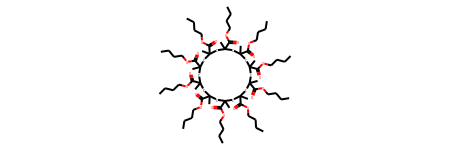

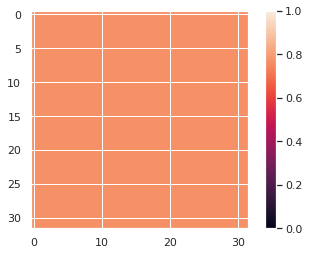

0


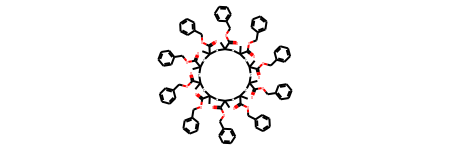

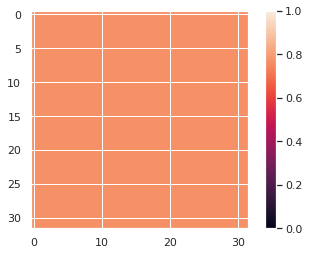

1


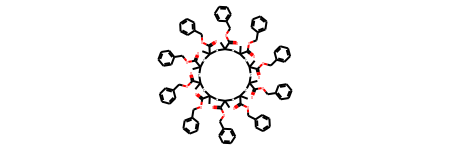

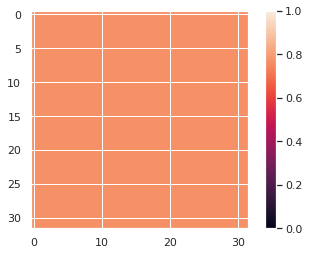

0


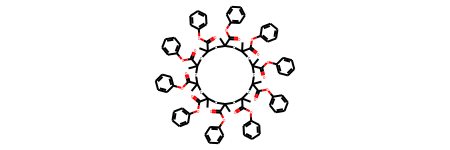

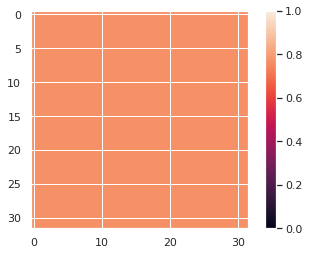

1


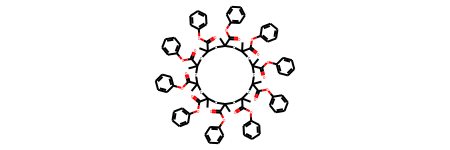

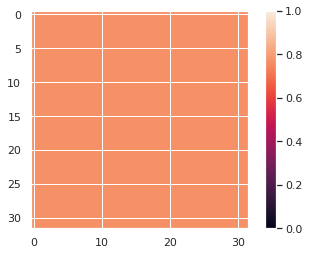

In [64]:
z_max=train_df["z_average"].max()
z_max=600
z_min=train_df["z_average"].min()
for (smiles,with_pva), smiles_df in pred_df.groupby(["circular_smiles_10","with_pva"]):
    predicted_z_average = smiles_df["predicted_roll_valid"].values.astype(float)
    #print(predicted_z_average)
    XY_pred = (predicted_z_average.reshape(len(concentrations),-1)).T
    plt.imshow(XY_pred,
                    #extent=[c_min,c_max,30,0],
         #            yticklabels=yticks
                    )
    plt.clim(0,1) 
    
    sd = train_df[(train_df["circular_smiles_10"]==smiles)]
    sd = sd[sd["with_pva"]==with_pva]
    #dps=[]
    #poly_conc=[]
    #z_average=[]
    #for (dp,polymer_concentration), point_group in sd.groupby(["dp","polymer_concentration"]):
    #    dps.append(dp)
    #    poly_conc.append(polymer_concentration)
    #    z_average.append(point_group["z_average"].mean())
    #new_dps=[np.argmin(np.abs(poly_deg-deg)) for deg in dps]
    #new_conc=[np.argmin(np.abs(concentrations-conc)) for conc in poly_conc]
    #plt.scatter(new_conc,new_dps,c=z_average,edgecolors="w")
    #plt.clim(0,z_max) 
    
    print(with_pva)
    display(Chem.MolFromSmiles(smiles))
    
    plt.colorbar()
    plt.show()
    plt.close()
    
    #xypred = prednp.reshape((d_res,c_res))

0


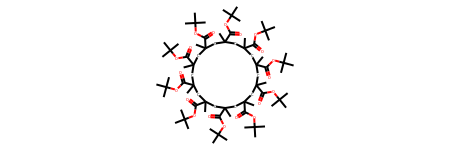

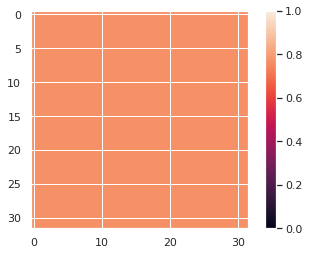

1


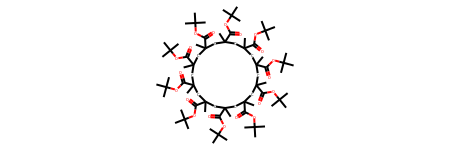

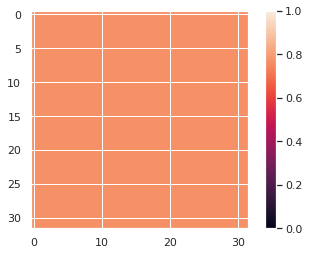

0


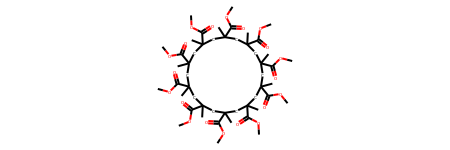

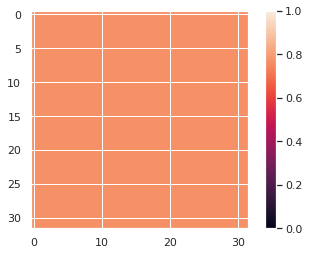

1


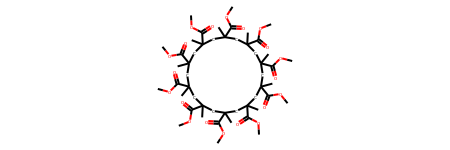

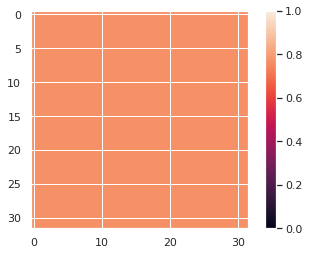

0


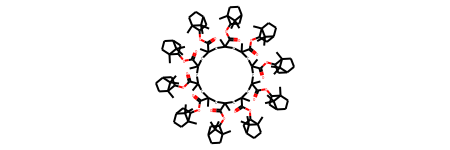

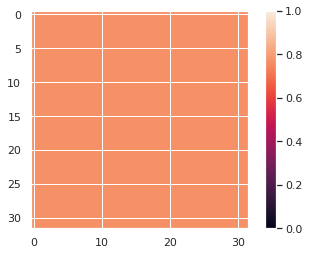

1


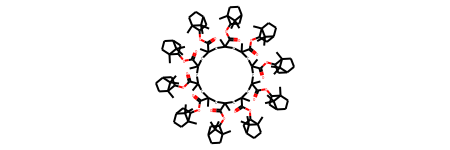

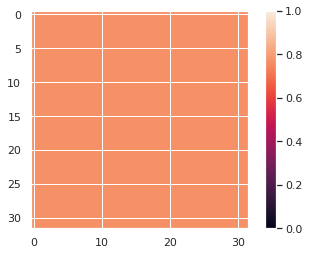

0


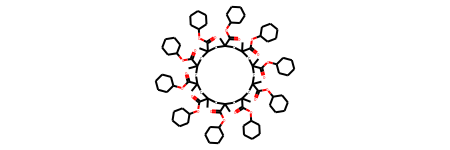

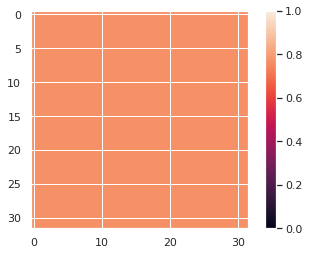

1


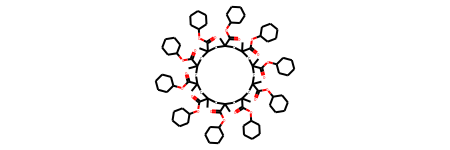

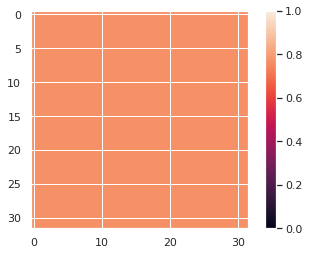

0


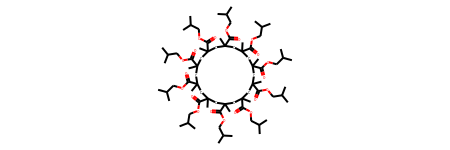

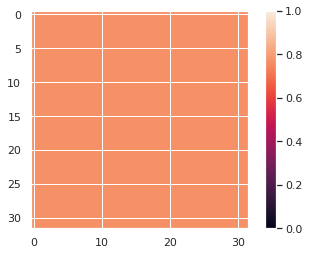

1


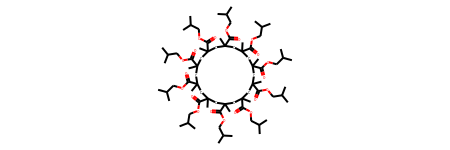

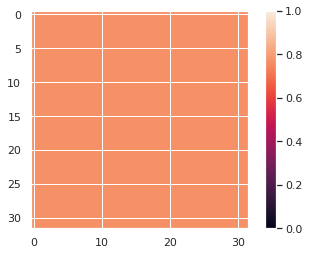

0


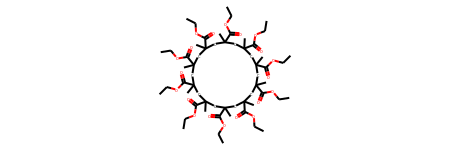

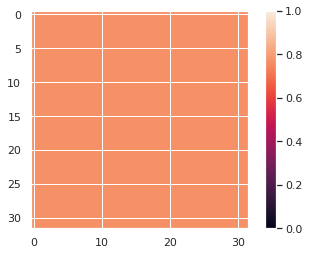

1


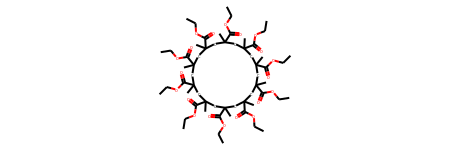

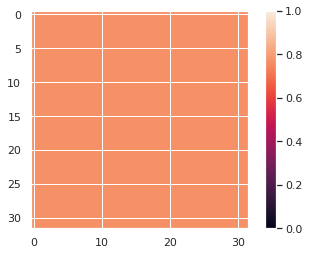

0


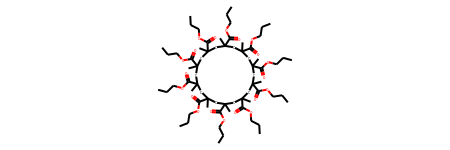

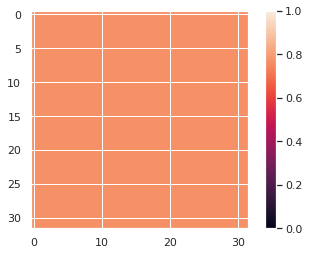

1


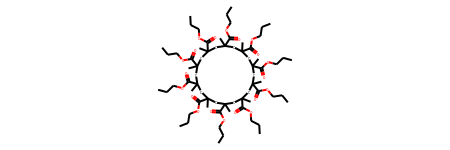

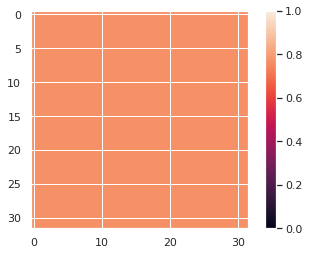

0


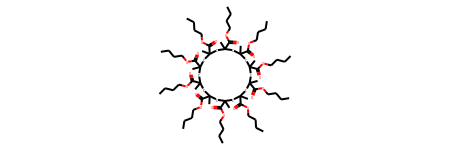

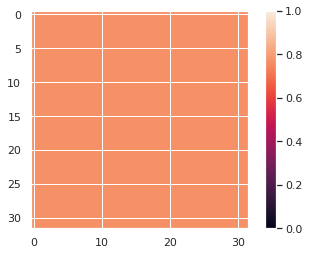

1


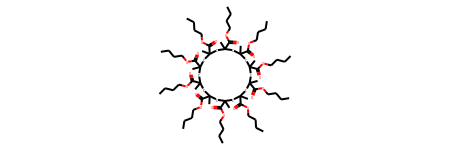

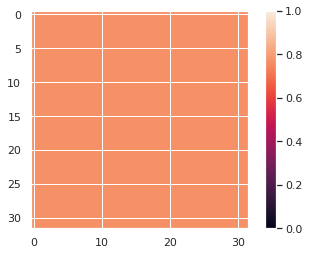

0


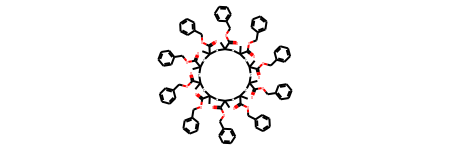

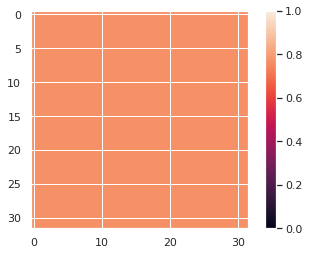

1


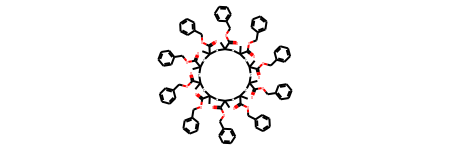

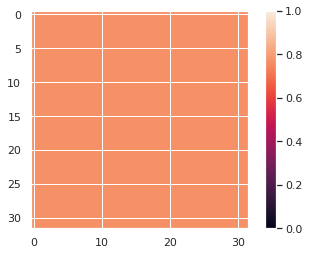

0


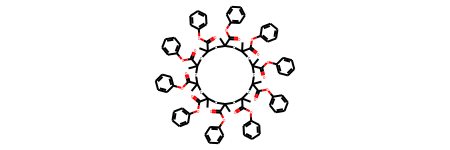

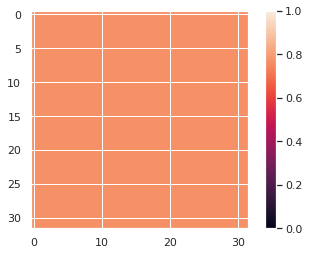

1


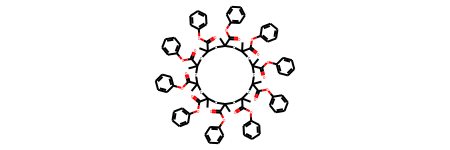

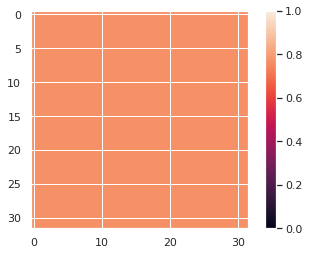

In [65]:
z_max=train_df["z_average"].max()
z_max=600
z_min=train_df["z_average"].min()
for (smiles,with_pva), smiles_df in pred_df.groupby(["circular_smiles_10","with_pva"]):
    predicted_z_average = smiles_df["predicted_roll_valid"].values.astype(float)
    #print(predicted_z_average)
    XY_pred = (predicted_z_average.reshape(len(concentrations),-1)).T
    plt.imshow(XY_pred,
                    #extent=[c_min,c_max,30,0],
         #            yticklabels=yticks
                    )
    plt.clim(0,1) 
    
    sd = train_df[(train_df["circular_smiles_10"]==smiles)]
    sd = sd[sd["with_pva"]==with_pva]
    #dps=[]
    #poly_conc=[]
    #z_average=[]
    #for (dp,polymer_concentration), point_group in sd.groupby(["dp","polymer_concentration"]):
    #    dps.append(dp)
    #    poly_conc.append(polymer_concentration)
    #    z_average.append(point_group["z_average"].mean())
    #new_dps=[np.argmin(np.abs(poly_deg-deg)) for deg in dps]
    #new_conc=[np.argmin(np.abs(concentrations-conc)) for conc in poly_conc]
    #plt.scatter(new_conc,new_dps,c=z_average,edgecolors="w")
    #plt.clim(0,z_max) 
    
    print(with_pva)
    display(Chem.MolFromSmiles(smiles))
    
    plt.colorbar()
    plt.show()
    plt.close()
    
    #xypred = prednp.reshape((d_res,c_res))

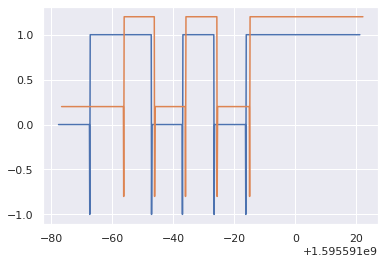

In [171]:
import json
import numpy as np
s='{"count":44,"next":null,"previous":null,"results":[{"time":"1595591021.162672","value":1.0,"table":"position_valve2","pack":null,"name":null,"idx":null},{"time":"1595591021.162421","value":1.0,"table":"position_valve1","pack":null,"name":null,"idx":null},{"time":"1595591001.065207","value":1.0,"table":"position_valve2","pack":null,"name":null,"idx":null},{"time":"1595591001.064932","value":1.0,"table":"position_valve1","pack":null,"name":null,"idx":null},{"time":"1595590984.193194","value":1.0,"table":"position_valve2","pack":null,"name":null,"idx":null},{"time":"1595590984.041099","value":-1.0,"table":"position_valve2","pack":null,"name":null,"idx":null},{"time":"1595590983.940465","value":0.0,"table":"position_valve2","pack":null,"name":null,"idx":null},{"time":"1595590983.938906","value":1.0,"table":"position_valve1","pack":null,"name":null,"idx":null},{"time":"1595590983.787240","value":-1.0,"table":"position_valve1","pack":null,"name":null,"idx":null},{"time":"1595590983.686665","value":0.0,"table":"position_valve1","pack":null,"name":null,"idx":null},{"time":"1595590980.988015","value":0.0,"table":"position_valve2","pack":null,"name":null,"idx":null},{"time":"1595590980.987768","value":0.0,"table":"position_valve1","pack":null,"name":null,"idx":null},{"time":"1595590973.563397","value":0.0,"table":"position_valve1","pack":null,"name":null,"idx":null},{"time":"1595590973.563168","value":0.0,"table":"position_valve2","pack":null,"name":null,"idx":null},{"time":"1595590973.410651","value":-1.0,"table":"position_valve1","pack":null,"name":null,"idx":null},{"time":"1595590973.410253","value":-1.0,"table":"position_valve2","pack":null,"name":null,"idx":null},{"time":"1595590973.310251","value":1.0,"table":"position_valve1","pack":null,"name":null,"idx":null},{"time":"1595590973.309655","value":1.0,"table":"position_valve2","pack":null,"name":null,"idx":null},{"time":"1595590963.185982","value":1.0,"table":"position_valve2","pack":null,"name":null,"idx":null},{"time":"1595590963.184447","value":1.0,"table":"position_valve1","pack":null,"name":null,"idx":null},{"time":"1595590963.032966","value":-1.0,"table":"position_valve2","pack":null,"name":null,"idx":null},{"time":"1595590963.032332","value":-1.0,"table":"position_valve1","pack":null,"name":null,"idx":null},{"time":"1595590962.932468","value":0.0,"table":"position_valve2","pack":null,"name":null,"idx":null},{"time":"1595590962.931907","value":0.0,"table":"position_valve1","pack":null,"name":null,"idx":null},{"time":"1595590960.935419","value":0.0,"table":"position_valve2","pack":null,"name":null,"idx":null},{"time":"1595590960.935175","value":0.0,"table":"position_valve1","pack":null,"name":null,"idx":null},{"time":"1595590953.060736","value":0.0,"table":"position_valve2","pack":null,"name":null,"idx":null},{"time":"1595590953.059682","value":0.0,"table":"position_valve1","pack":null,"name":null,"idx":null},{"time":"1595590952.907889","value":-1.0,"table":"position_valve2","pack":null,"name":null,"idx":null},{"time":"1595590952.906954","value":-1.0,"table":"position_valve1","pack":null,"name":null,"idx":null},{"time":"1595590952.807289","value":1.0,"table":"position_valve2","pack":null,"name":null,"idx":null},{"time":"1595590952.806412","value":1.0,"table":"position_valve1","pack":null,"name":null,"idx":null},{"time":"1595590942.936748","value":1.0,"table":"position_valve2","pack":null,"name":null,"idx":null},{"time":"1595590942.784249","value":-1.0,"table":"position_valve2","pack":null,"name":null,"idx":null},{"time":"1595590942.683692","value":0.0,"table":"position_valve2","pack":null,"name":null,"idx":null},{"time":"1595590940.913621","value":0.0,"table":"position_valve2","pack":null,"name":null,"idx":null},{"time":"1595590940.913379","value":1.0,"table":"position_valve1","pack":null,"name":null,"idx":null},{"time":"1595590932.813219","value":1.0,"table":"position_valve1","pack":null,"name":null,"idx":null},{"time":"1595590932.660349","value":-1.0,"table":"position_valve1","pack":null,"name":null,"idx":null},{"time":"1595590932.559873","value":0.0,"table":"position_valve1","pack":null,"name":null,"idx":null},{"time":"1595590922.436258","value":0.0,"table":"position_valve2","pack":null,"name":null,"idx":null},{"time":"1595590922.436020","value":0.0,"table":"position_valve2","pack":null,"name":null,"idx":null},{"time":"1595590922.434514","value":0.0,"table":"position_valve1","pack":null,"name":null,"idx":null},{"time":"1595590922.434219","value":0.0,"table":"position_valve1","pack":null,"name":null,"idx":null}]}'

data=json.loads(s)

ts=[]
for d in data['results']:
    ts.append(float(d['time']))
    
ts=np.array(list(sorted(list(set(ts)))))

v1=np.zeros_like(ts)
v1[:]=np.nan
v2=np.zeros_like(ts)
v2[:]=np.nan

for d in data['results']:
    t=float(d['time'])
    tix=np.argmin(np.abs(ts-t))
    if d["table"] == 'position_valve2':
        v2[tix]=int(d['value'])
    if d["table"] == 'position_valve1':
        v1[tix]=int(d['value'])
        
plt.plot(ts[~np.isnan(v1)],v1[~np.isnan(v1)])
plt.plot(ts[~np.isnan(v2)]+1,v2[~np.isnan(v2)]+0.2)

In [165]:
dt=ts[1:]-ts[:-1]
dt.max()/60

38.77131460110346

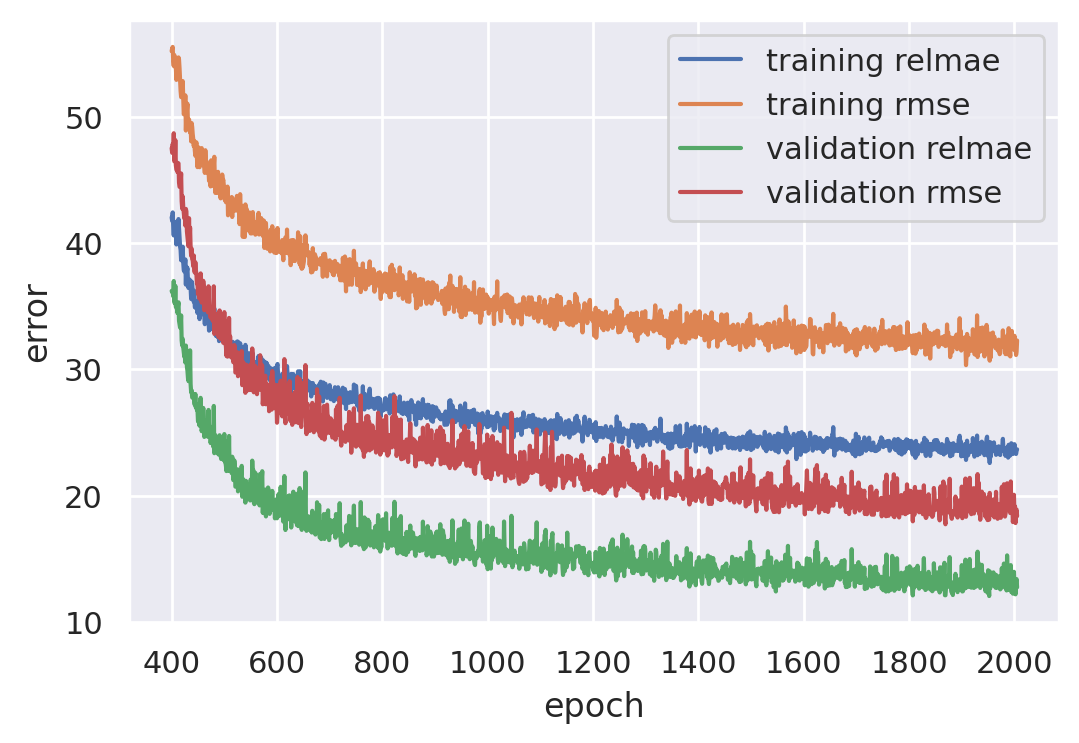

In [107]:
import pickle
td = pickle.load(open("/home/julian/.smartchem/np_model_10/training/training_metrics.mtr", "rb"))
from_epoch=400
steps=[]
epochs=[]
metrics=[]
for step, data in td.items():
    if step == "epochs":
        continue
    steps.append(step)
    for epoch, dmetrics in data.items():
        if epoch not in epochs:
            epochs.append(epoch)
        for metric,mdata in dmetrics.items():
            if metric not in metrics:
                metrics.append(metric)
steps.remove('testing')

epochs=np.sort(epochs)
data=np.zeros((len(steps),len(metrics),len(epochs)))*np.nan
plt.figure(dpi=200)
for i,step in enumerate(steps):
    for j,metric in enumerate(metrics):
        for k,epoch in enumerate(epochs):
            try:
                data[i,j,k] = td[step][epoch][metric]
            except KeyError:
                pass
        plt.plot(epochs[from_epoch:],data[i,j,from_epoch:],label=step+" "+metric)
plt.xlabel("epoch")
plt.ylabel("error")
plt.legend()

In [64]:
import pickle
td = pickle.load(open("/home/julian/.smartchem/np_model_1596610350/training/training_metrics.mtr", "rb"))

from_epoch=0
to_epoch=2600
steps=[]
epochs=[]
metrics=[]
for step, data in td.items():
    if step == "epochs":
        continue
    steps.append(step)
    for epoch, dmetrics in data.items():
        if epoch not in epochs:
            epochs.append(epoch)
        for metric,mdata in dmetrics.items():
            if metric not in metrics:
                metrics.append(metric)

epochs=np.sort(epochs)
data=np.zeros((len(steps),len(metrics),len(epochs)))*np.nan

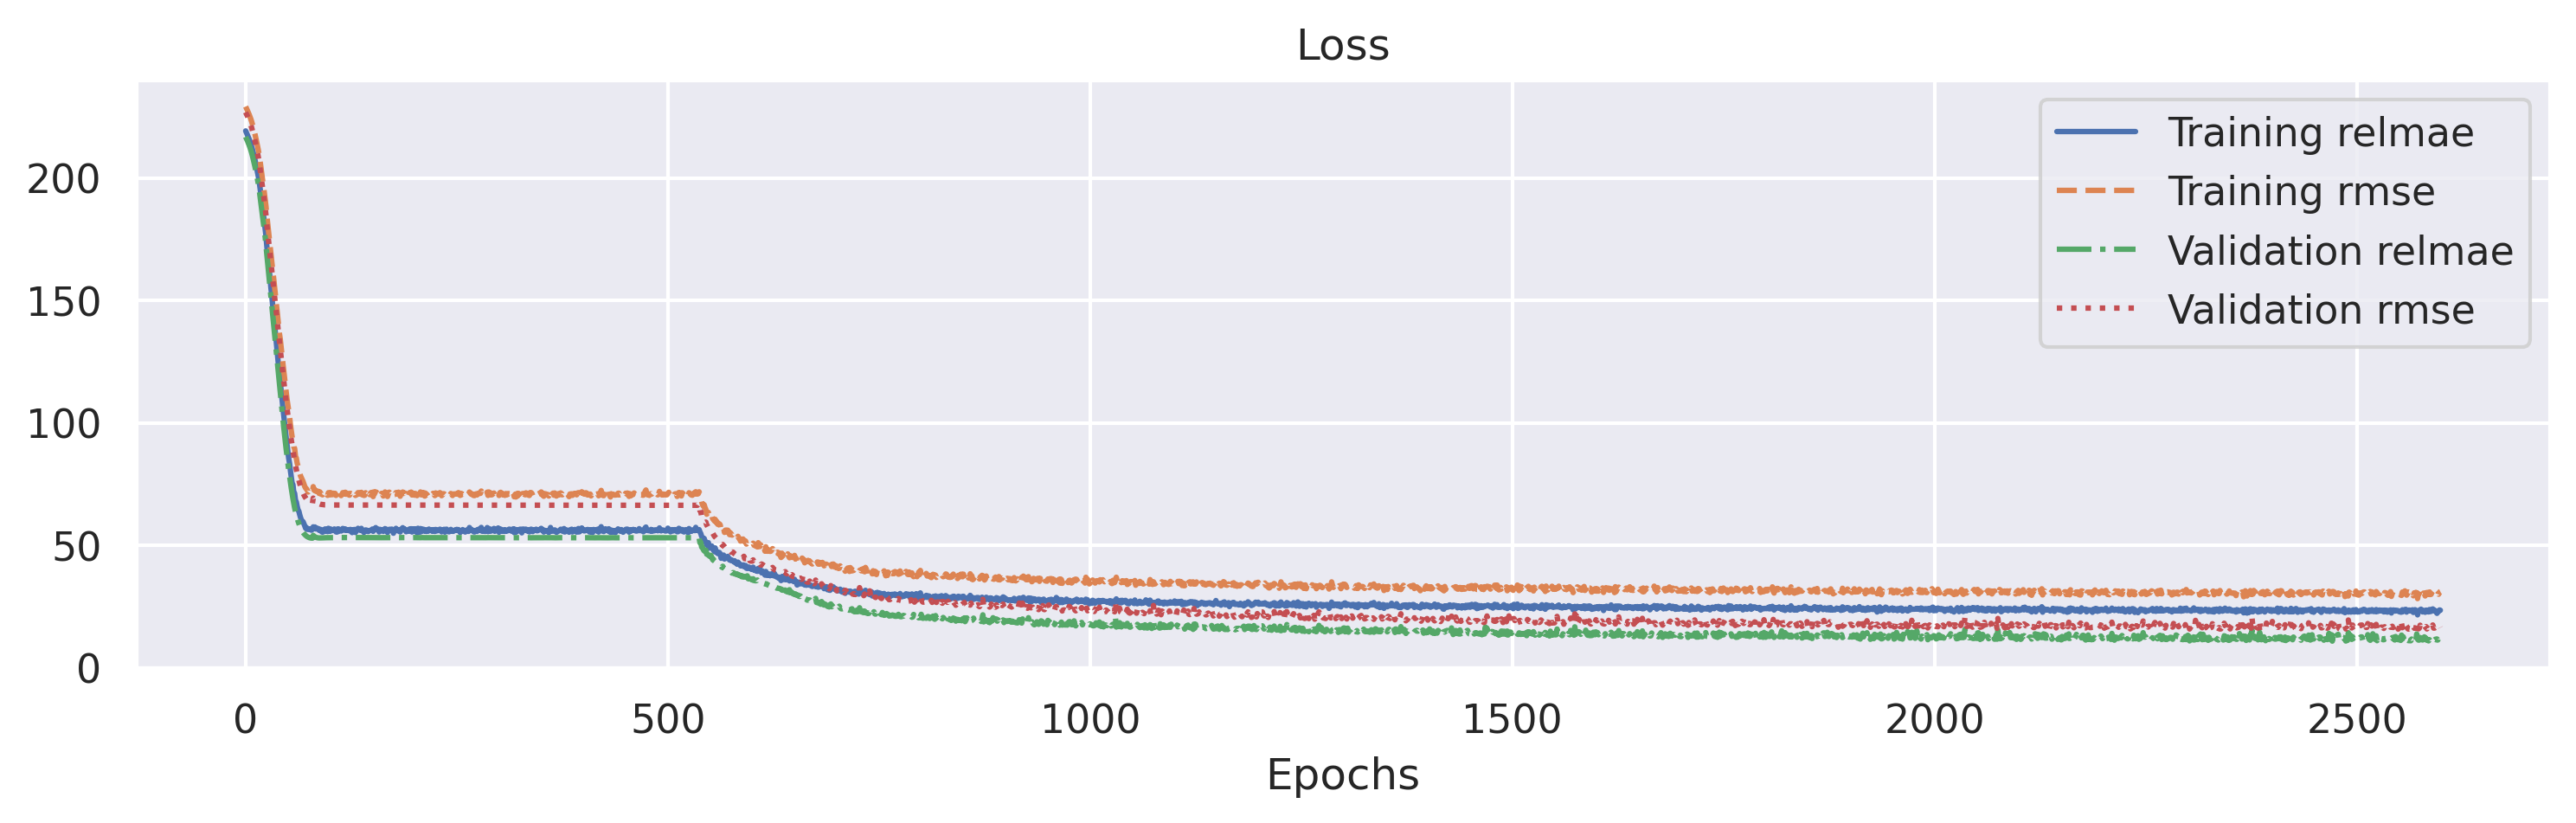

In [87]:
plt.figure(dpi=300,figsize=(12,3))
steps=[s for s in steps if s in ["training","validation"]]
b=iter(["-","--",'-.',':'])
for i,step in enumerate(steps):
    for j,metric in enumerate(metrics):
        for k,epoch in enumerate(epochs):
            try:
                data[i,j,k] = td[step][epoch][metric]
            except KeyError:
                pass
        plt.plot(epochs[from_epoch:to_epoch],data[i,j,from_epoch:to_epoch],next(b),label=step.capitalize()+" "+metric)
#plt.tight_layout()
plt.xlabel("Epochs")
plt.title("Loss")
plt.legend()

In [91]:
stat_df = test_df.groupby(["dp","additive","polymer_concentration"]).describe()['z_average']

In [92]:
stat_df["var"] = stat_df["std"]**2



stat_df["coeff_of_var"] = stat_df['std']/stat_df['mean']
stat_df["coeff_of_var_star"] = stat_df["coeff_of_var"]*(1+1/(4*stat_df["count"]))

stat_df["std_error"] = stat_df["std"]/np.sqrt(stat_df["count"])
stat_df["rel_std_error"] = stat_df["std_error"]/stat_df['mean']


stat_df_res = stat_df.reset_index()

In [97]:
100*(stat_df_res["coeff_of_var_star"].mean())

3.71890466554715

In [43]:


os.path.basename(os.path.dirname(os.path.abspath(train_data)))

'data'

In [41]:
os.path.basename(os.path.abspath(train_data))

'train_data_size_smiles_kept_z_average_cutoff_500_dispersity_cutoff_0.3_cutoff_size_disp_300_cutoff_group_size_3_cutoff_min_conc_3_valid_threshold_0.2_valid_threshold_0.2.csv'